<font size=+3 color="#141474"><center><b>Titanic Competition: A Beginner-friendly Approach to Top 3% with Ensemble Learning</b></center></font>

## 학습 목표
1. **탐색적 데이터 분석(EDA)**을 통해 생존에 영향을 미치는 요인을 파악할 수 있다
2. **Feature Engineering**을 통해 새로운 유용한 특성(Title, Family_Survival 등)을 생성할 수 있다
3. 여러 **머신러닝 모델**(Naive Bayes, Logistic Regression, SVM, Decision Tree, Random Forest, XGBoost)을 비교할 수 있다
4. **GridSearchCV**를 사용하여 하이퍼파라미터 튜닝을 수행할 수 있다
5. **앙상블 학습(Voting Classifier)**을 구현하여 모델 성능을 향상시킬 수 있다
6. **교차 검증(Cross Validation)**을 통해 모델 성능을 평가할 수 있다

## 주요 내용
- Kaggle Titanic 데이터셋 분석
- 성별, 나이, 등급, 요금별 생존률 시각화
- 이름에서 호칭(Title) 추출 및 가족 생존 여부 Feature Engineering
- 8가지 분류 알고리즘 비교 및 튜닝
- Hard/Soft Voting 앙상블 구현

---

<img src="https://images.unsplash.com/photo-1542614370-156b709e78f8?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1350&q=80" width = 400>
<center>Photo by Annie Spratt (Unsplash)</center>

# 소개

Kaggle의 [Titanic ML 경진대회](https://www.kaggle.com/c/titanic)에 대한 저의 시도에 오신 것을 환영합니다! 이 노트북에서는:

- **탐색적 데이터 분석(EDA)**을 수행하여 승객 생존에 영향을 미친 요인에 대한 인사이트를 얻고,
- **Feature Engineering**을 통해 더 나은 특성을 만들고 모델을 개선하며,
- 승객이 난파선에서 생존했는지 예측하는 여러 **머신러닝 모델**을 구축합니다.

추론/워크플로우를 설명하는 텍스트를 포함하여 이 커널을 가능한 한 <font size=+0 color="#BF570F"><b>초보자 친화적</b></font>으로 만들었습니다. 머신러닝 개념('SVC란?', 'k-Nearest Neighbors에서 k는 무엇인가?' 등)에 대해 자세히 다루지 않았지만, 댓글에서 무엇이든 질문해 주세요.

유용하다고 생각되면 <font size=+0 color="red"><b>upvote</b></font>를 고려해 주세요!
    
<br>

**목차**

1. [소개](#Introduction)
2. [라이브러리](#Libraries)
3. [데이터 가져오기](#Getting-the-Data)
4. [데이터 살펴보기](#A-Quick-Look-at-our-Data)
5. [탐색적 데이터 분석](#Exploratory-Data-Analysis)
6. [데이터 준비](#Preparing-Data)
7. [머신러닝 모델 구축](#Building-Machine-Learning-Models)
8. [결론](#Conclusions)

## 실행 환경 감지

이 노트북은 다음 세 가지 환경에서 실행할 수 있습니다:
- **Kaggle**: Kaggle 커널에서 실행 (데이터 경로: /kaggle/input/titanic/)
- **Google Colab**: Colab에서 실행 (Kaggle API로 데이터 다운로드)
- **Local PC**: 로컬 환경에서 실행 (데이터 경로: data/titanic/)

아래 코드가 자동으로 환경을 감지하여 적절한 설정을 적용합니다.

In [4]:
# import google.colab


In [5]:
import os

print(os.path.abspath("."))
print(os.getcwd())
# colab에도 루트폴더에 아래 kaggle 폴더를 만들어놔서 이걸로 구분 못함
print(os.path.exists('/kaggle/input'))

c:\Users\user\github\DataScience\scikit-learn
c:\Users\user\github\DataScience\scikit-learn
False


In [6]:
import os
import sys

def detect_environment():
    # 1. Google Colab 감지 (가장 확실한 방법)
    if 'google.colab' in sys.modules:
        return 'colab'
    
    # 2. Kaggle 환경 변수 감지 (KAGGLE_KERNEL_RUN_TYPE은 캐글 내부 변수임)
    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
        return 'kaggle'
    
    # 3. Local 환경
    return 'local'

ENV = detect_environment()
print(f'실행 환경: {ENV}')

# 환경별 데이터 경로 설정
if ENV == 'kaggle':
    DATA_PATH = '/kaggle/input/titanic/'
elif ENV == 'colab':
    DATA_PATH = '/content/'
else:  # local
    DATA_PATH = 'data/titanic/'
    
print(f'데이터 경로: {DATA_PATH}')

실행 환경: local
데이터 경로: data/titanic/


## Kaggle API 설정 (Colab 전용)

**이 섹션은 Google Colab에서만 실행됩니다.**

Google Colab 환경에서 Kaggle 데이터셋을 다운로드하려면 Kaggle API 인증이 필요합니다.
- `kaggle.json` 파일에는 Kaggle 계정의 API 토큰이 저장되어 있습니다
- 이 파일을 `~/.kaggle/` 디렉토리에 복사하고 적절한 권한을 설정해야 합니다
- 보안을 위해 권한을 600(소유자만 읽기/쓰기 가능)으로 설정합니다
- Kaggle이나 Local 환경에서는 이 셀들이 건너뛰어집니다

In [7]:
# Colab 환경에서만 실행
if ENV == 'colab':
    # kaggle.json을 .kaggle폴더를 생성한 후에 그 폴더로 복사한다.
    # 폴더를 생성
    !mkdir -p ~/.kaggle
    # 생성된 폴더로 복사
    !cp kaggle.json ~/.kaggle
    # 읽기/쓰기 권한을 준다.
    !chmod 600 ~/.kaggle/kaggle.json
    print('Kaggle API 설정 완료')
else:
    print(f'Colab이 아닌 {ENV} 환경이므로 Kaggle API 설정을 건너뜁니다.')

Colab이 아닌 local 환경이므로 Kaggle API 설정을 건너뜁니다.


**파일 복사 확인**: `kaggle.json` 파일이 올바르게 복사되었는지 확인합니다. `-rw-------` 권한(600)이 설정되어 있어야 합니다.

In [8]:
# Colab 환경에서만 실행 - kaggle.json 파일 확인
if ENV == 'colab':
    !sudo ls -al ~/.kaggle 
else:
    print(f'{ENV} 환경에서는 이 단계를 건너뜁니다.')

local 환경에서는 이 단계를 건너뜁니다.


**Kaggle 데이터셋 다운로드**: Kaggle API를 사용하여 Titanic 경진대회 데이터셋을 다운로드합니다. `train.csv`(훈련 데이터)와 `test.csv`(테스트 데이터)가 `/content` 폴더에 저장됩니다.

In [9]:
# train.csv와 test.csv파일을 현재 폴더에 다운로드
# 로컬에서도 사용 가능 (kaggle 패키지 설치 필요)
if ENV== 'colab':
    !kaggle competitions download -c titanic

# 환경설정 및 패키지 불러오기

필요한 라이브러리를 불러오고 노트북 전체에서 사용할 파라미터(그래프 설정 등)를 설정합니다. 주로 사용하는 라이브러리는 다음과 같습니다:

- Pandas: 데이터 처리 및 분석
- Seaborn과 Matplotlib: 데이터 시각화
- Scikit-learn: 머신러닝 모델 구축

In [10]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 7.2 MB/s eta 0:00:10
   - -------------------------------------- 2.1/72.0 MB 5.3 MB/s eta 0:00:14
   - -------------------------------------- 2.9/72.0 MB 4.7 MB/s eta 0:00:15
   -- ------------------------------------- 3.9/72.0 MB 4.7 MB/s eta 0:00:15
   -- ------------------------------------- 5.2/72.0 MB 5.0 MB/s eta 0:00:14
   --- ------------------------------------ 6.3/72.0 MB 5.1 MB/s eta 0:00:13
   ---- ----------------------------------- 7.9/72.0 MB 5.3 MB/s eta 0:00:13
   ----- ---------------------------------- 9.7/72.0 MB 5.6 MB/s eta 0:00:12
   ------ --------------------------------- 11.3/72.0 MB 5.9 MB/s eta 0:00:11
   ------- -------------------------------- 13.1/72.0 MB 6.2 MB/s eta 0:00:10
   -------- ------------------------------- 14.9/72.0 MB 6.4 MB/s eta 0:00:09
   -------- ------------------------------- 16.0/72.0 MB 6.3 MB/s eta 0:00:09
  

In [11]:
# 향후 버전이 올라갈 때 변경될 사항 등을 알려주는 경고 메시지(warning message) 무시

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# 소수점 3째자리 미만을 지수로 표현
# pandas 2.0+에서는 'display.precision' 사용
pd.set_option('display.precision', 3)

import matplotlib as mpl
import matplotlib.pyplot as plt

# 그래프를 더 높은 해상도로 출력한다.
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('dark')

# 그래프를 그릴때 레이블, 타이틀, legend 폰트 크기 지정
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

# 데이터 전처리 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler 
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

# 머신러닝 알고리즘 패키지 가져오기
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier

# 성능을 평가하기 위한 기준 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

print ('Libraries Loaded!')

Libraries Loaded!


**패키지 설명**:
- `warnings`: 경고 메시지 제어
- `numpy`, `pandas`: 수치 연산 및 데이터 조작
- `matplotlib`, `seaborn`: 데이터 시각화
- `sklearn.preprocessing`: 데이터 전처리 (인코딩, 스케일링)
- `sklearn.model_selection`: 교차 검증 및 하이퍼파라미터 튜닝
- 분류 알고리즘: Naive Bayes, Logistic Regression, KNN, SVM, Decision Tree, Random Forest, XGBoost, AdaBoost

In [12]:
# 앞에서 pd.set_option('display.precision', 3)를 설정한 것을 확인해 보자.
pd.set_option('display.precision', 3)
pd.DataFrame({'x': [0.5], 'y': [0.3123456]})

,x,y
0,0.5,0.312


**precision 설정 확인**: `display.precision` 옵션이 제대로 적용되어 소수점 3자리까지만 표시되는지 테스트합니다.

# 데이터셋 불러오기

In [13]:
import os

# local은 DATA_PATH=os.getcwd()+'data/'+'titanic/', colab은 DATA_PATH='/content/'
# kaggle은 DATA_PATH='/kaggle/input/titanic/'
if ENV == 'colab':
    DATA_PATH = '/content/'
elif ENV == 'kaggle':
    DATA_PATH = '/kaggle/input/titanic/'
else:
    HOME = os.getcwd()
    DATA_PATH = os.path.join(HOME,'data','titanic')

DATA_PATH

'c:\\Users\\user\\github\\DataScience\\scikit-learn\\data\\titanic'

In [14]:
trainCSV = os.path.join(DATA_PATH, 'train.csv')
testCSV = os.path.join(DATA_PATH, 'test.csv')

In [15]:
# 환경에 따른 데이터 경로로 학습/테스트 데이터 읽어오기
train_df = pd.read_csv(trainCSV)
test_df = pd.read_csv(testCSV)

print(f'데이터 로드 완료 (경로: {DATA_PATH})')
print(train_df.shape, test_df.shape)

데이터 로드 완료 (경로: c:\Users\user\github\DataScience\scikit-learn\data\titanic)
(891, 12) (418, 11)


**데이터 로드**: `pd.read_csv()`로 CSV 파일을 DataFrame으로 읽어옵니다. `shape` 속성으로 행과 열의 개수를 확인합니다. 훈련 데이터(891행, 12열)는 `Survived` 열을 포함하고, 테스트 데이터(418행, 11열)는 이를 포함하지 않습니다.

훈련 세트에는 레이블(각 승객의 생존 여부)이 포함되어 있어 열의 개수가 다릅니다.

두 데이터프레임을 하나로 합치겠습니다. 테스트 세트의 인스턴스들은 'Survived' 열에 **NaN** 값을 가지게 됩니다:

In [16]:
# train data와 test data를 합쳐준다.
all_data = pd.concat([train_df, test_df])

**데이터 결합**: `pd.concat()`으로 훈련/테스트 데이터를 하나로 합칩니다. 이렇게 하면 동일한 전처리를 양쪽 데이터에 일관되게 적용할 수 있습니다. 테스트 데이터의 `Survived` 열은 NaN으로 채워집니다.

**데이터 확인**: `shape`(행/열 개수), `head()`(처음 5행), `tail()`(마지막 5행), `value_counts()`(값별 개수)로 결합된 데이터를 검토합니다.

In [17]:
all_data.shape

(1309, 12)

In [18]:
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


In [19]:
all_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.050,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.250,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.050,NaN,S
417,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.358,NaN,C


In [20]:
print ('Combined set: {} rows and {} columns'.format(all_data.shape[0], all_data.shape[1]))
print ('\nSurvived?: ')
all_data['Survived'].value_counts(dropna = False)

Combined set: 1309 rows and 12 columns

Survived?: 


Survived
0.0    549
NaN    418
1.0    342
Name: count, dtype: int64

# 데이터 살펴보기

이 단계에서는 테스트 세트를 잠시 제쳐두고 훈련 세트에 집중하겠습니다.

`head()` 메서드를 사용하여 훈련 세트의 상위 5개 행을 살펴볼 수 있습니다:

In [21]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


각 속성의 의미는 다음과 같습니다:

- **PassengerId**: 각 승객에게 부여된 ID
- **Survived**: 타겟 속성 (1 = 생존, 0 = 사망)
- **Pclass**: 티켓 등급 (1 = 1등석, 2 = 2등석, 3 = 3등석)
- **Name**, **Sex**, **Age**: 이름, 성별, 나이
- **SibSp**: 타이타닉에 탑승한 형제/자매 및 배우자 수
- **Parch**: 타이타닉에 탑승한 부모 및 자녀 수
- **Ticket**: 티켓 번호
- **Fare**: 승객 요금 (파운드 단위)
- **Cabin**: 승객의 객실 번호
- **Embarked**: 승선 항구 (C = Cherbourg, Q = Queenstown, S = Southampton)

'PassengerId'는 각 승객에게 고유하므로 제거할 수 있습니다:

In [22]:
# 'PassengerId' column 삭제
train_df.drop('PassengerId', axis = 1, inplace = True)

In [23]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


`info()` 메서드는 각 속성의 데이터 타입과 결측값 개수 등 유용한 정보를 제공합니다:

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


훈련 세트는 891개의 인스턴스와 11개의 열(10개 속성 + 타겟 속성)로 구성되어 있습니다. 6개는 수치형 속성이고, 5개는 범주형 속성입니다.

결측값을 더 자세히 살펴보겠습니다:

**결측치 분석**: `isnull().sum()`으로 각 컬럼의 결측치 개수를 확인합니다. Cabin(77%), Age(20%), Embarked(0.2%)에 결측치가 있습니다. 이 정보는 데이터 전처리 전략을 수립하는 데 중요합니다.

In [25]:
# 컬럼별 결측치의 갯수를 확인한다.
missing_counts = train_df.isnull().sum().sort_values(ascending = False)
missing_counts

Cabin       687
Age         177
Embarked      2
Name          0
Pclass        0
Survived      0
Sex           0
Parch         0
SibSp         0
Fare          0
Ticket        0
dtype: int64

In [26]:
# 결측치를 전체데이터 대비 퍼센테이지로 계산
percent = (train_df.isnull().sum()*100/train_df.shape[0]).sort_values(ascending = False)
percent

Cabin       77.104
Age         19.865
Embarked     0.224
Name         0.000
Pclass       0.000
Survived     0.000
Sex          0.000
Parch        0.000
SibSp        0.000
Fare         0.000
Ticket       0.000
dtype: float64

In [27]:
missing_df = pd.concat([missing_counts, percent], axis = 1, keys = ['Counts', '%'])
print('Missing values: ')
display(missing_df.head().style.background_gradient(cmap = 'Reds', axis = 0))

Missing values: 


,Counts,%
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Name,0,0.000000
Pclass,0,0.000000


'Age'와 'Embarked' 열의 결측값 대체는 어렵지 않습니다. 각각 중앙값과 최빈값을 사용하면 됩니다. 그러나 'Cabin' 속성은 75% 이상이 결측값이므로 제거해야 할 것입니다.

`describe()` 메서드는 수치형 속성의 통계 요약을 제공합니다:

In [28]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,714.000,891.000,891.000,891.000
mean,0.384,2.309,29.699,0.523,0.382,32.204
std,0.487,0.836,14.526,1.103,0.806,49.693
min,0.000,1.000,0.420,0.000,0.000,0.000
25%,0.000,2.000,20.125,0.000,0.000,7.910
50%,0.000,3.000,28.000,0.000,0.000,14.454
75%,1.000,3.000,38.000,1.000,0.000,31.000
max,1.000,3.000,80.000,8.000,6.000,512.329


**통계 요약 및 분포 시각화**: `describe()`는 수치형 변수의 기술통계량(평균, 표준편차, 사분위수 등)을 보여줍니다. 히스토그램으로 각 변수의 분포를 시각적으로 확인합니다.

주목할 점은 다음과 같습니다:

- 승객의 **38%** 만 **생존**했습니다
- **평균 나이**는 약 **30**세이고, **중앙값**은 **28**세입니다 (따라서 결측값 대체에 어느 것을 사용해도 큰 차이가 없습니다)
- 'SibSp'와 'Parch'의 중앙값은 모두 0입니다 (대부분의 승객이 **혼자** 탑승했습니다)
- 평균 요금은 £32.20입니다
- 속성들의 **스케일이 다르므로** 머신러닝 알고리즘에 입력하기 전에 처리가 필요합니다

각 수치형 속성의 히스토그램을 그려 스케일 차이를 빠르게 시각화할 수 있습니다.

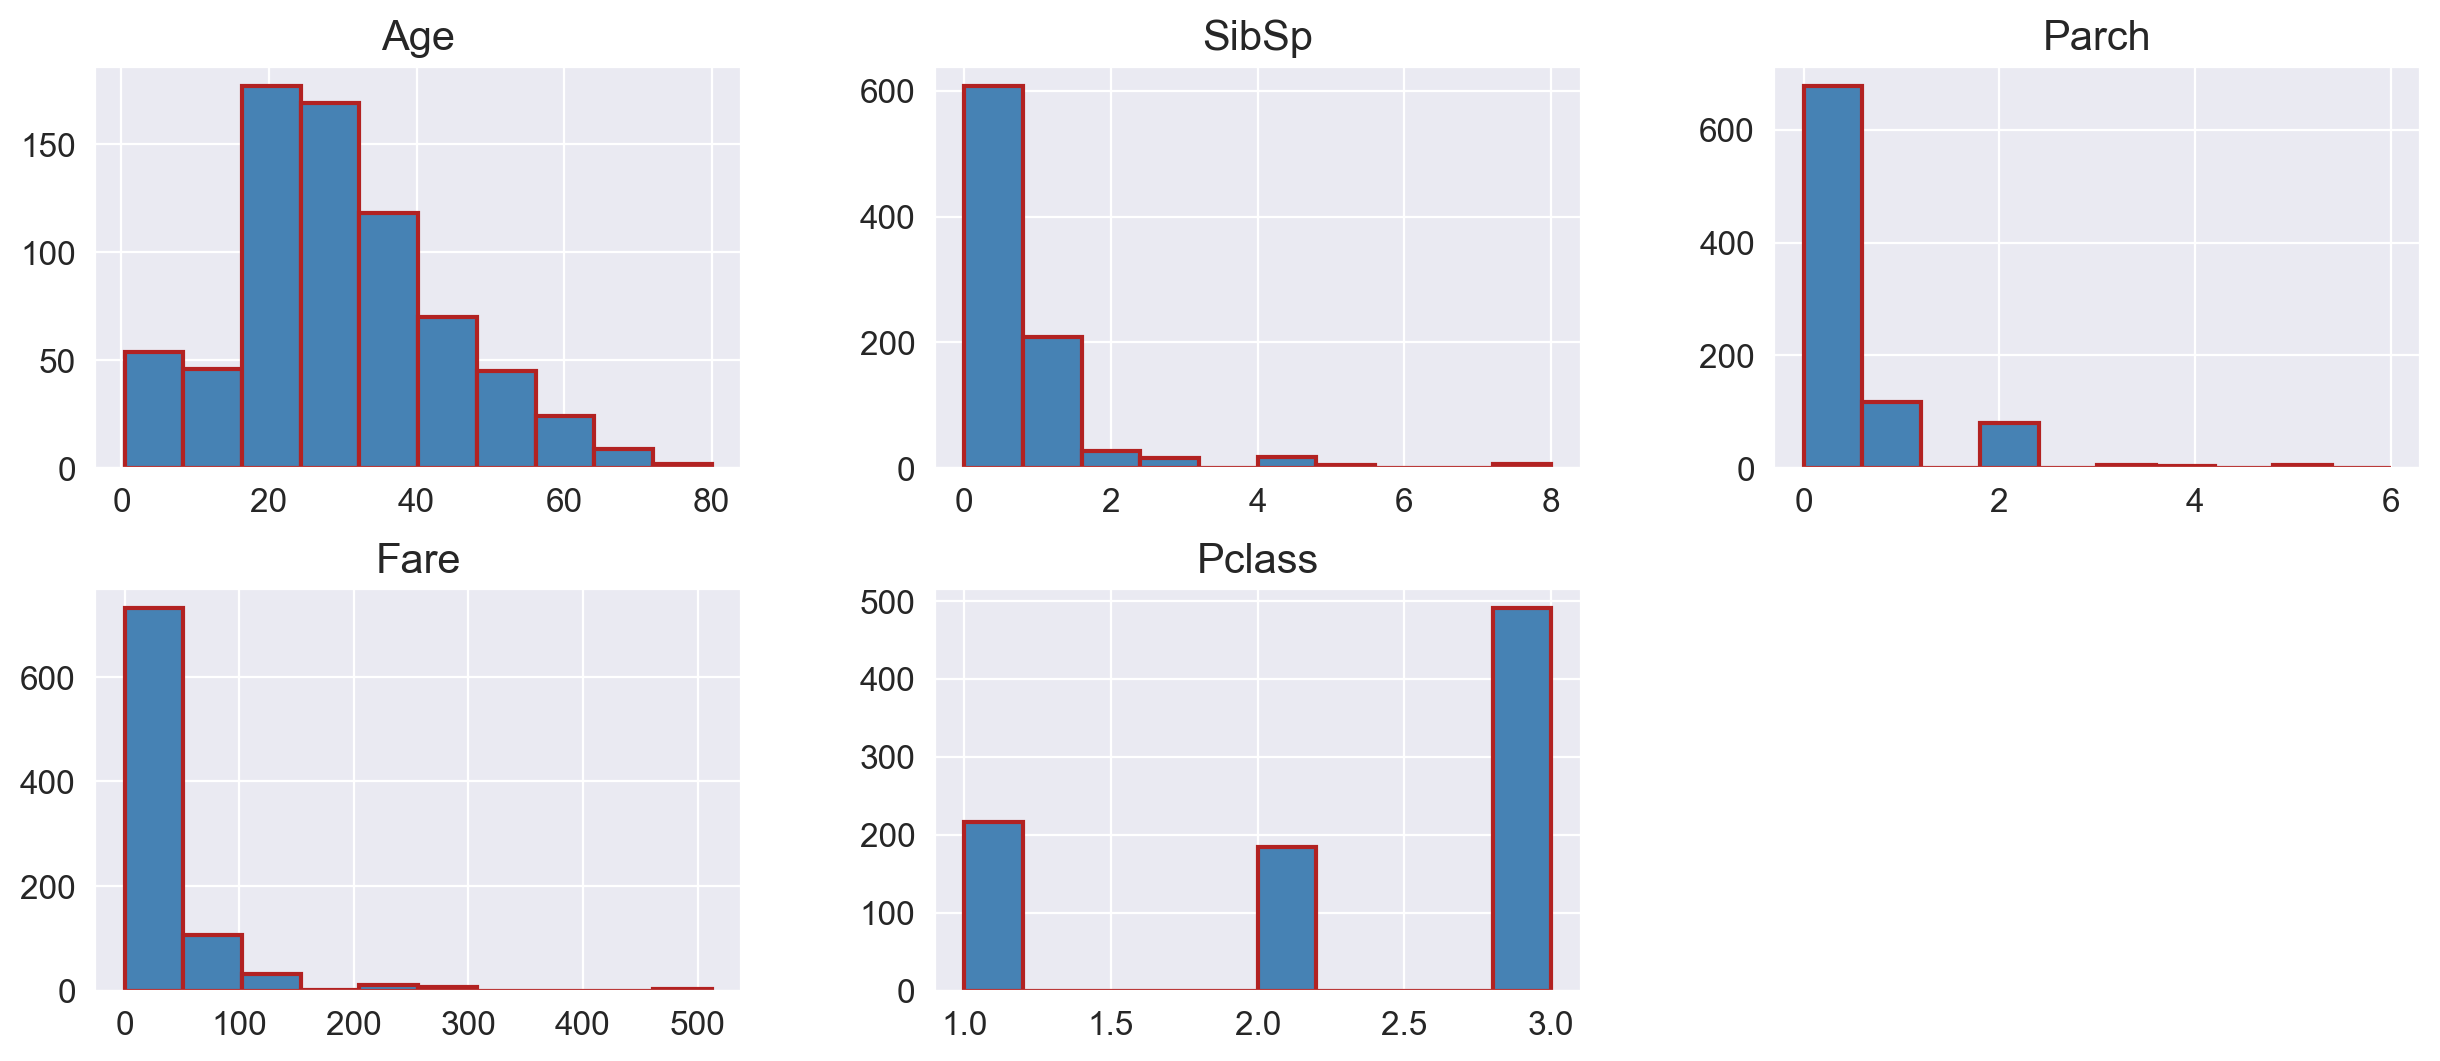

In [29]:
num_atts = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
train_df[num_atts].hist(figsize = (15, 6), color = 'steelblue', edgecolor = 'firebrick', linewidth = 1.5, layout = (2, 3));

대부분의 승객은:

- **젊은** 편이었고 (나이 < 40),
- **혼자** 탑승했으며 (SibSp와 Parch가 0),
- **낮은 요금**을 지불하고 **3등석**에 탑승했습니다.

**성별 시각화**: `countplot`으로 성별에 따른 생존자/사망자 수를, `barplot`으로 성별 생존률을 시각화합니다. 여성의 생존률(74%)이 남성(19%)보다 훨씬 높습니다.

# 탐색적 데이터 분석 (EDA)

(거의) 모든 속성을 더 자세히 살펴보겠습니다.

## 1. 성별 (Gender)

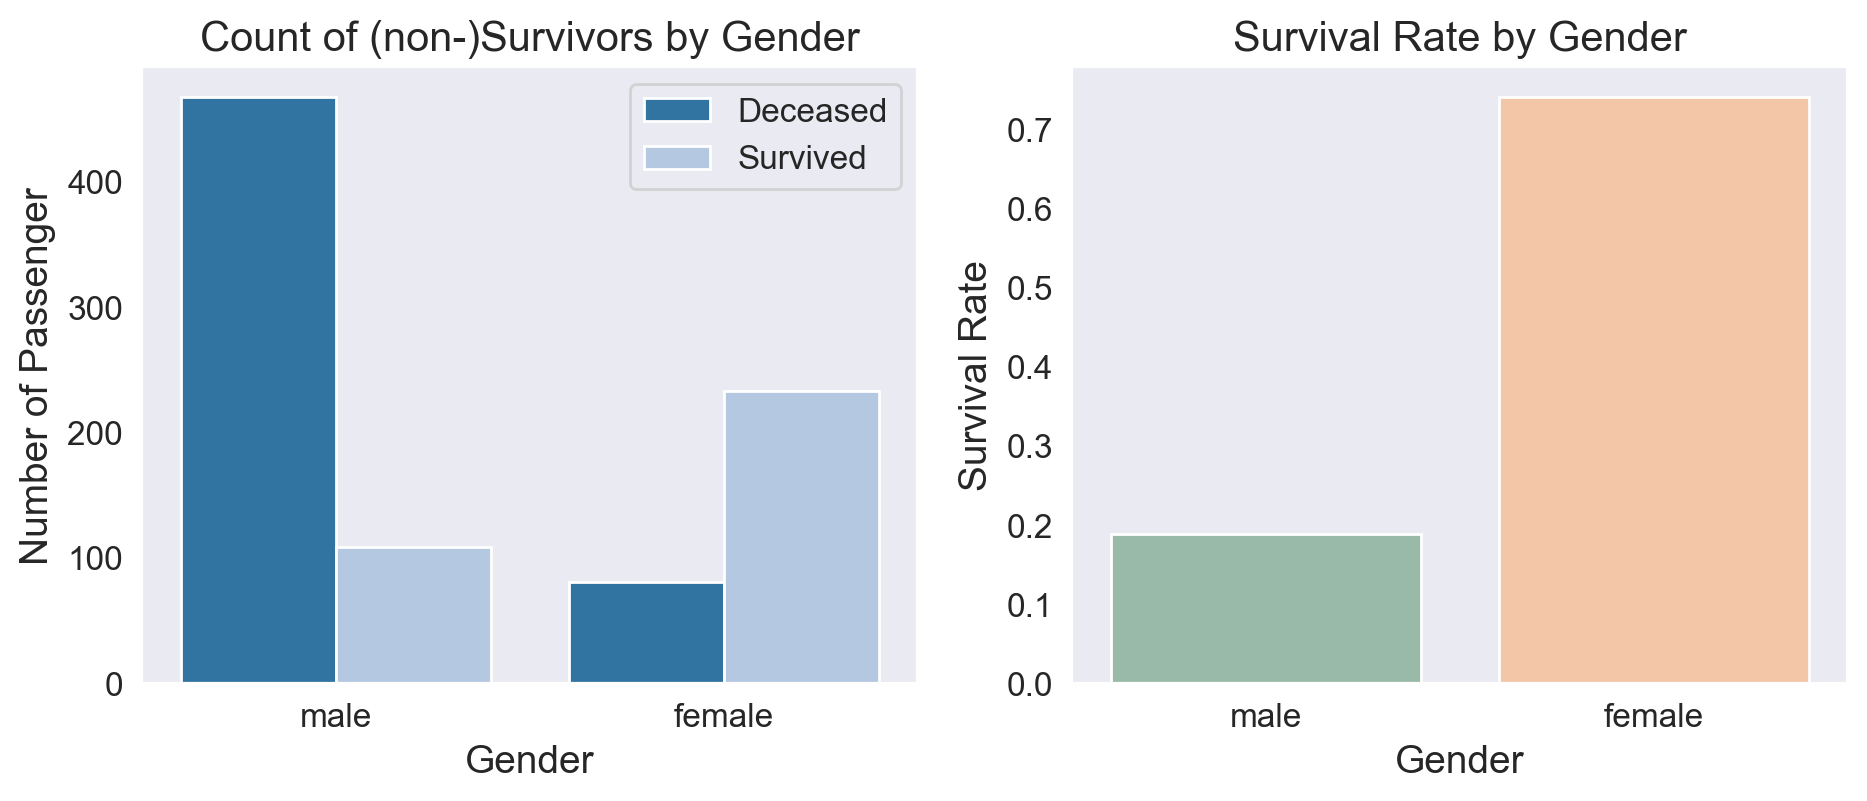

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 4))

sns.countplot(x = 'Sex', hue = 'Survived', data = train_df,  palette = 'tab20', ax = ax1) 
ax1.set_title('Count of (non-)Survivors by Gender')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Number of Passenger')
ax1.legend(labels = ['Deceased', 'Survived'])

sns.barplot(x = 'Sex', y = 'Survived', data = train_df,  palette = ['#94BFA7', '#FFC49B'], ci = None, ax = ax2)
ax2.set_title('Survival Rate by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Survival Rate');

**교차표 분석**: `pd.crosstab()`으로 성별과 생존 여부 간의 관계를 비율로 확인합니다. `normalize='index'`는 행 기준으로 비율을 계산합니다.

In [31]:
# 'Sex' column과 'Survived' column간의 표를 보여준다.
pd.crosstab(train_df['Sex'], train_df['Survived'], normalize = 'index')

Survived,0,1
Sex,,
female,0.258,0.742
male,0.811,0.189


**성별 데이터 분리**: 남성과 여성 데이터를 별도의 DataFrame으로 분리하여 성별에 따른 나이 분포를 개별적으로 분석할 수 있도록 합니다.

배에는 남성이 여성보다 더 많았습니다. 그러나 **여성의 생존률이 더 높았습니다** (여성의 생존률은 거의 75%인 반면 남성은 20%에 불과합니다!).

[위키피디아](https://en.wikipedia.org/wiki/Titanic)에 따르면 구명보트 탑승 시 "여성과 어린이 우선" 원칙이 적용되었습니다. 따라서 여성 외에도 어린 사람들이 유리했습니다. 이를 염두에 두고 나이 분포를 살펴보겠습니다.

## 2. 나이 (Age)

**나이 분포 시각화**: `histplot`으로 전체, 여성, 남성의 나이별 생존 분포를 비교합니다. 어린이(0-4세)와 15-45세 여성의 생존률이 높음을 확인할 수 있습니다.

In [32]:
men = train_df[train_df['Sex']  == 'male']
women = train_df[train_df['Sex']  == 'female']

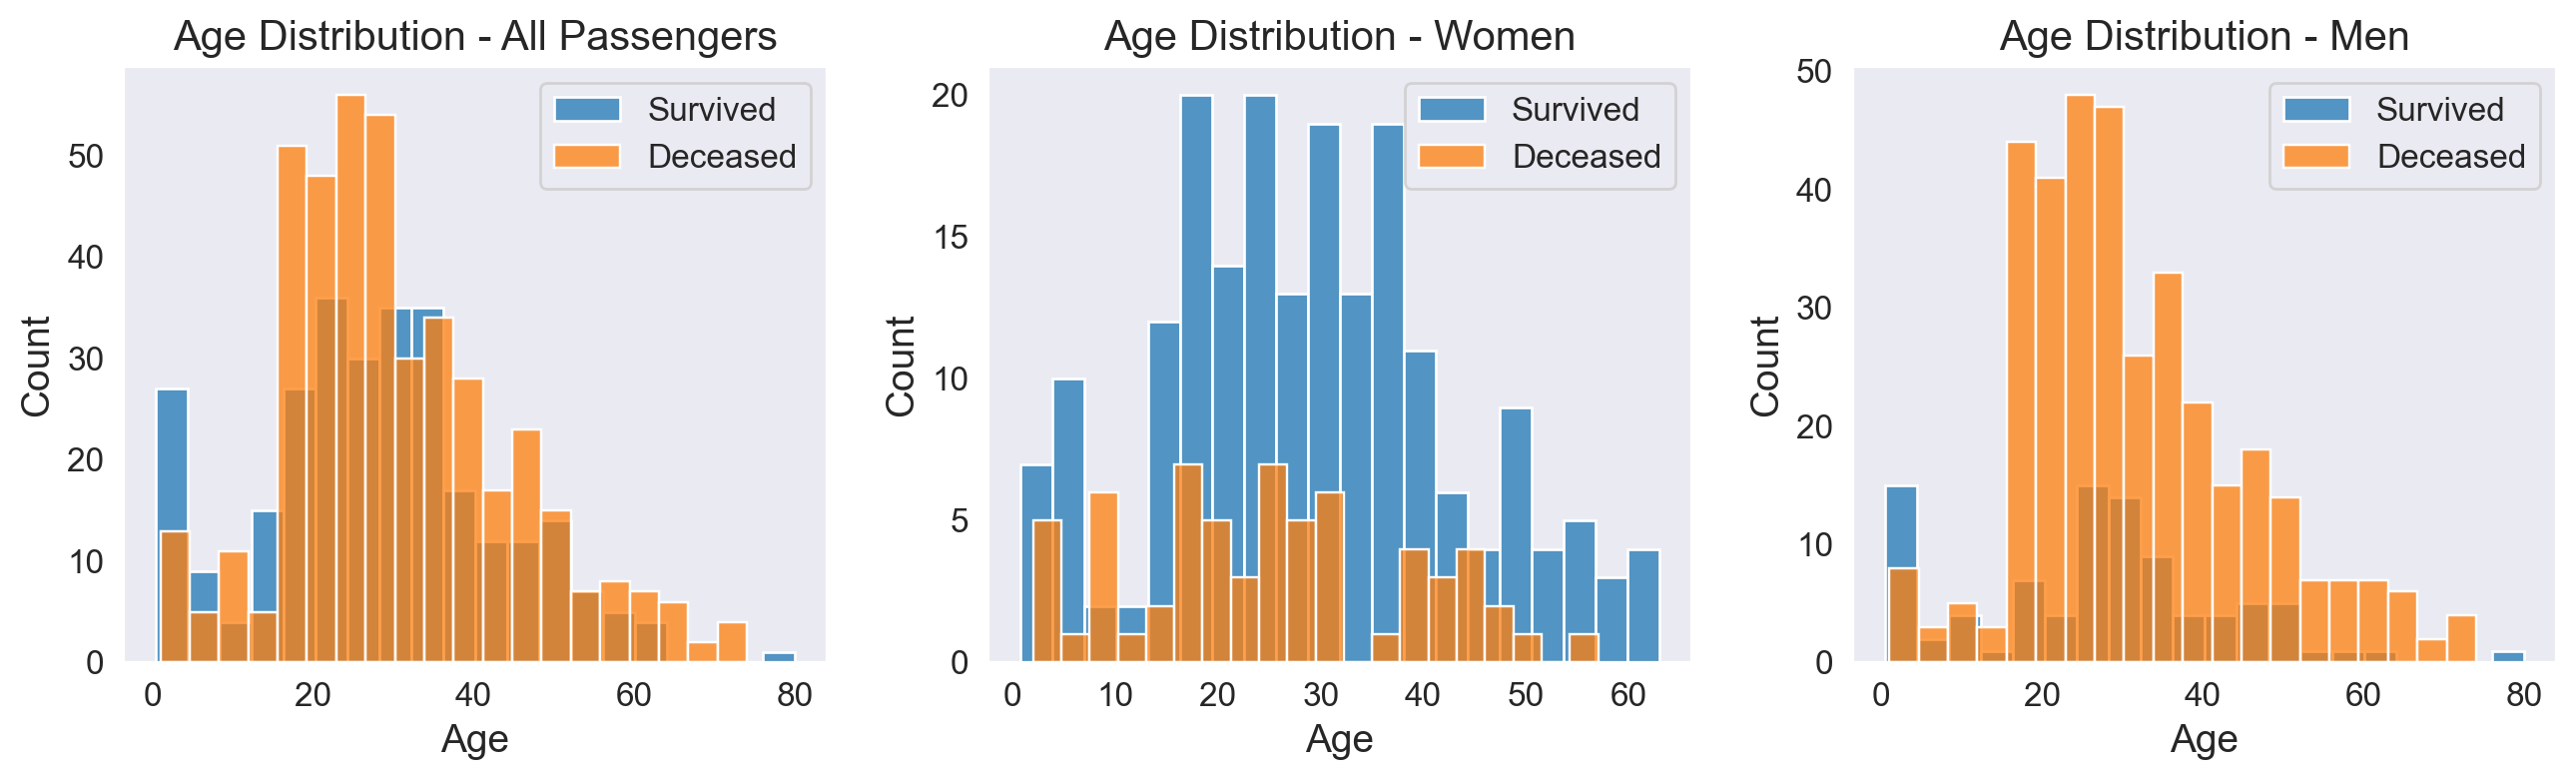

In [33]:
# 나이 분포 시각화
# seaborn 0.11+에서 distplot은 deprecated됨 → histplot 사용
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (13, 4))

sns.histplot(train_df[train_df['Survived'] == 1]['Age'].dropna(), bins = 20, label = 'Survived', ax = ax1, kde = False)
sns.histplot(train_df[train_df['Survived'] == 0]['Age'].dropna(), bins = 20, label = 'Deceased', ax = ax1, kde = False)
ax1.legend()
ax1.set_title('Age Distribution - All Passengers')

sns.histplot(women[women['Survived'] == 1]['Age'].dropna(), bins = 20, label = 'Survived', ax = ax2, kde = False)
sns.histplot(women[women['Survived'] == 0]['Age'].dropna(), bins = 20, label = 'Deceased', ax = ax2, kde = False)
ax2.legend()
ax2.set_title('Age Distribution - Women')

sns.histplot(men[men['Survived'] == 1]['Age'].dropna(), bins = 20, label = 'Survived', ax = ax3, kde = False)
sns.histplot(men[men['Survived'] == 0]['Age'].dropna(), bins = 20, label = 'Deceased', ax = ax3, kde = False)
ax3.legend()
ax3.set_title('Age Distribution - Men')

plt.tight_layout();

**나이 구간화(Binning)**<br>
* 연속형 변수인 나이를 15년 단위 구간으로 나눕니다. <br>
* `//`는 정수 나눗셈으로, 0-14세=0, 15-29세=15 등으로 변환됩니다. <br>
* 구간별 평균 생존률을 계산하여 나이와 생존의 관계를 파악합니다.

**연령대에 따라** **생존률이 크게 다른** 것이 분명합니다. 예를 들어, 두 성별 모두 15세에서 45세 사이에서 생존 확률이 더 높습니다. 또한 어린 나이(0-4세)에서의 급증은 영유아와 어린 아이들의 생존 확률이 더 높다는 것을 보여줍니다.

특정 연령대에서 생존이 유리한 것처럼 보이므로, 알고리즘에 입력하기 전에 'Age'를 **구간화(bin)**하는 것이 유용할 수 있습니다. 15년 간격을 사용하겠습니다.

**승선항 시각화**<br>
* Southampton(S), Cherbourg(C), Queenstown(Q) 세 항구에서 승선한 승객들의 생존 분포를 확인합니다. 
* 대부분의 승객은 Southampton에서 승선했습니다.

In [34]:
# train_df['Age_Bin'] = pd.qcut(train_df['Age'], 4)  # Quantile-based discretization
train_df['Age_Bin'] = (train_df['Age']//15)*15
# pandas 2.0+에서는 numeric_only=True 명시
train_df[['Age_Bin', 'Survived']].groupby(['Age_Bin']).mean(numeric_only=True)

,Survived
Age_Bin,
0.0,0.577
15.0,0.363
30.0,0.423
45.0,0.404
60.0,0.240
75.0,1.000


## 3. 승선 항구 (Port of Embarkation)

**객실 등급(Pclass) 분석**: `value_counts()`로 등급별 승객 수를 확인하고, 등급별 생존률을 시각화합니다. 1등급 > 2등급 > 3등급 순으로 생존률이 높습니다.

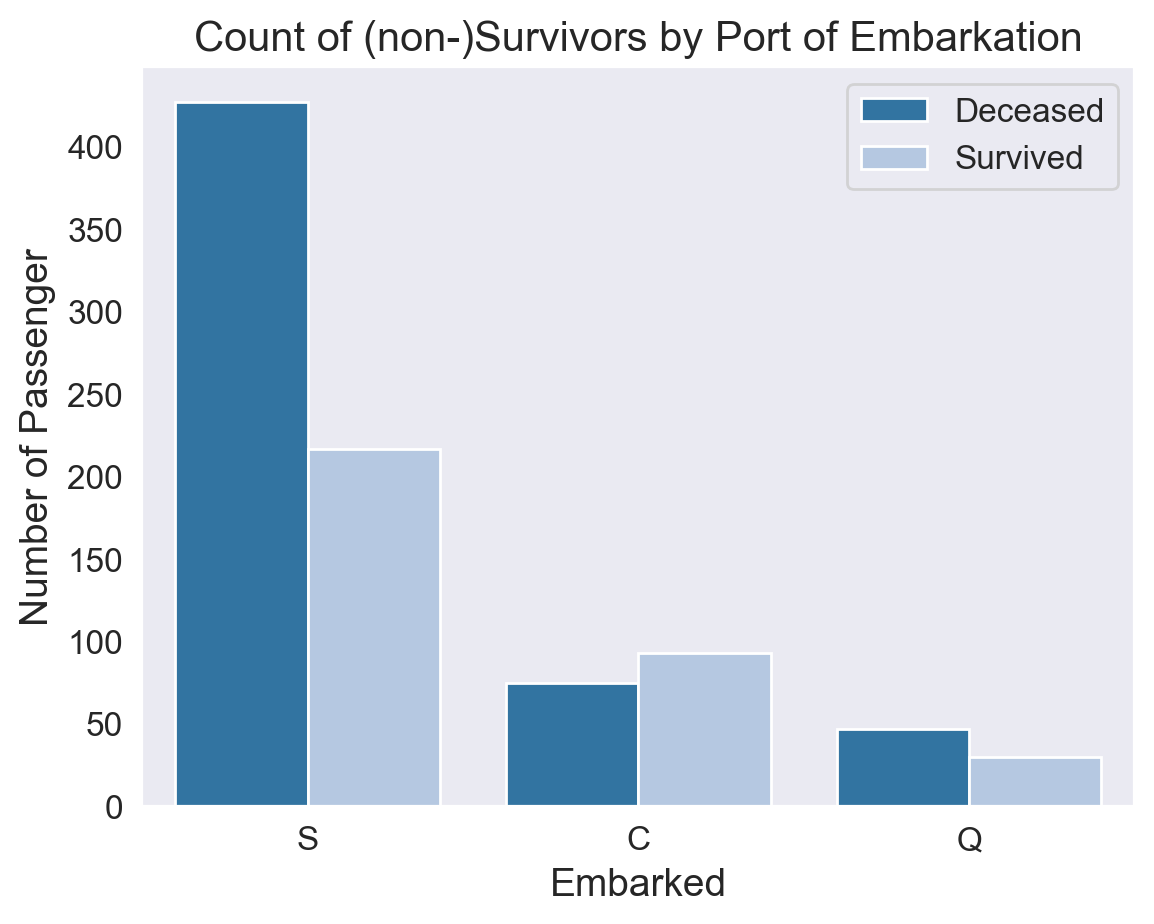

In [35]:
sns.countplot(x = 'Embarked', hue = 'Survived', data = train_df,  palette = 'tab20') 
plt.ylabel('Number of Passenger')
plt.title('Count of (non-)Survivors by Port of Embarkation')
plt.legend(['Deceased', 'Survived']);

대부분의 승객은 배가 출항한 Southampton에서 승선했습니다. 생존자와 사망자 모두에서 가장 높은 수치를 보입니다. Cherbourg는 두 번째로 많은 승객이 승선했으며, 흥미롭게도 절반 이상이 생존했습니다.

데이터를 보면서 이 속성이 유용할지 확신이 없었습니다. 결국 배는 모든 승객에게 같은 지점에서 같은 시간에 침몰했으므로 어디서 승선했는지는 중요하지 않습니다. 그러나 테스트해본 결과 이 속성을 포함하면 모델 성능이 오히려 나빠졌으므로 **무시해도 됩니다**.

## 4. 객실 등급 (Pclass)

**요금 분포 분석**: `boxplot`으로 등급별 요금 분포를, `kdeplot`(커널밀도추정)으로 생존 여부에 따른 요금 분포를 비교합니다. 높은 요금 = 높은 등급 = 높은 생존률의 관계를 확인합니다.

In [36]:
print ('Number of passengers in each class:')
train_df['Pclass'].value_counts()

Number of passengers in each class:


Pclass
3    491
1    216
2    184
Name: count, dtype: int64

**요금 구간화**: `pd.qcut()`으로 요금을 5개의 분위수(quantile) 기반 구간으로 나눕니다. 동일한 개수의 샘플이 각 구간에 포함되도록 분할합니다.

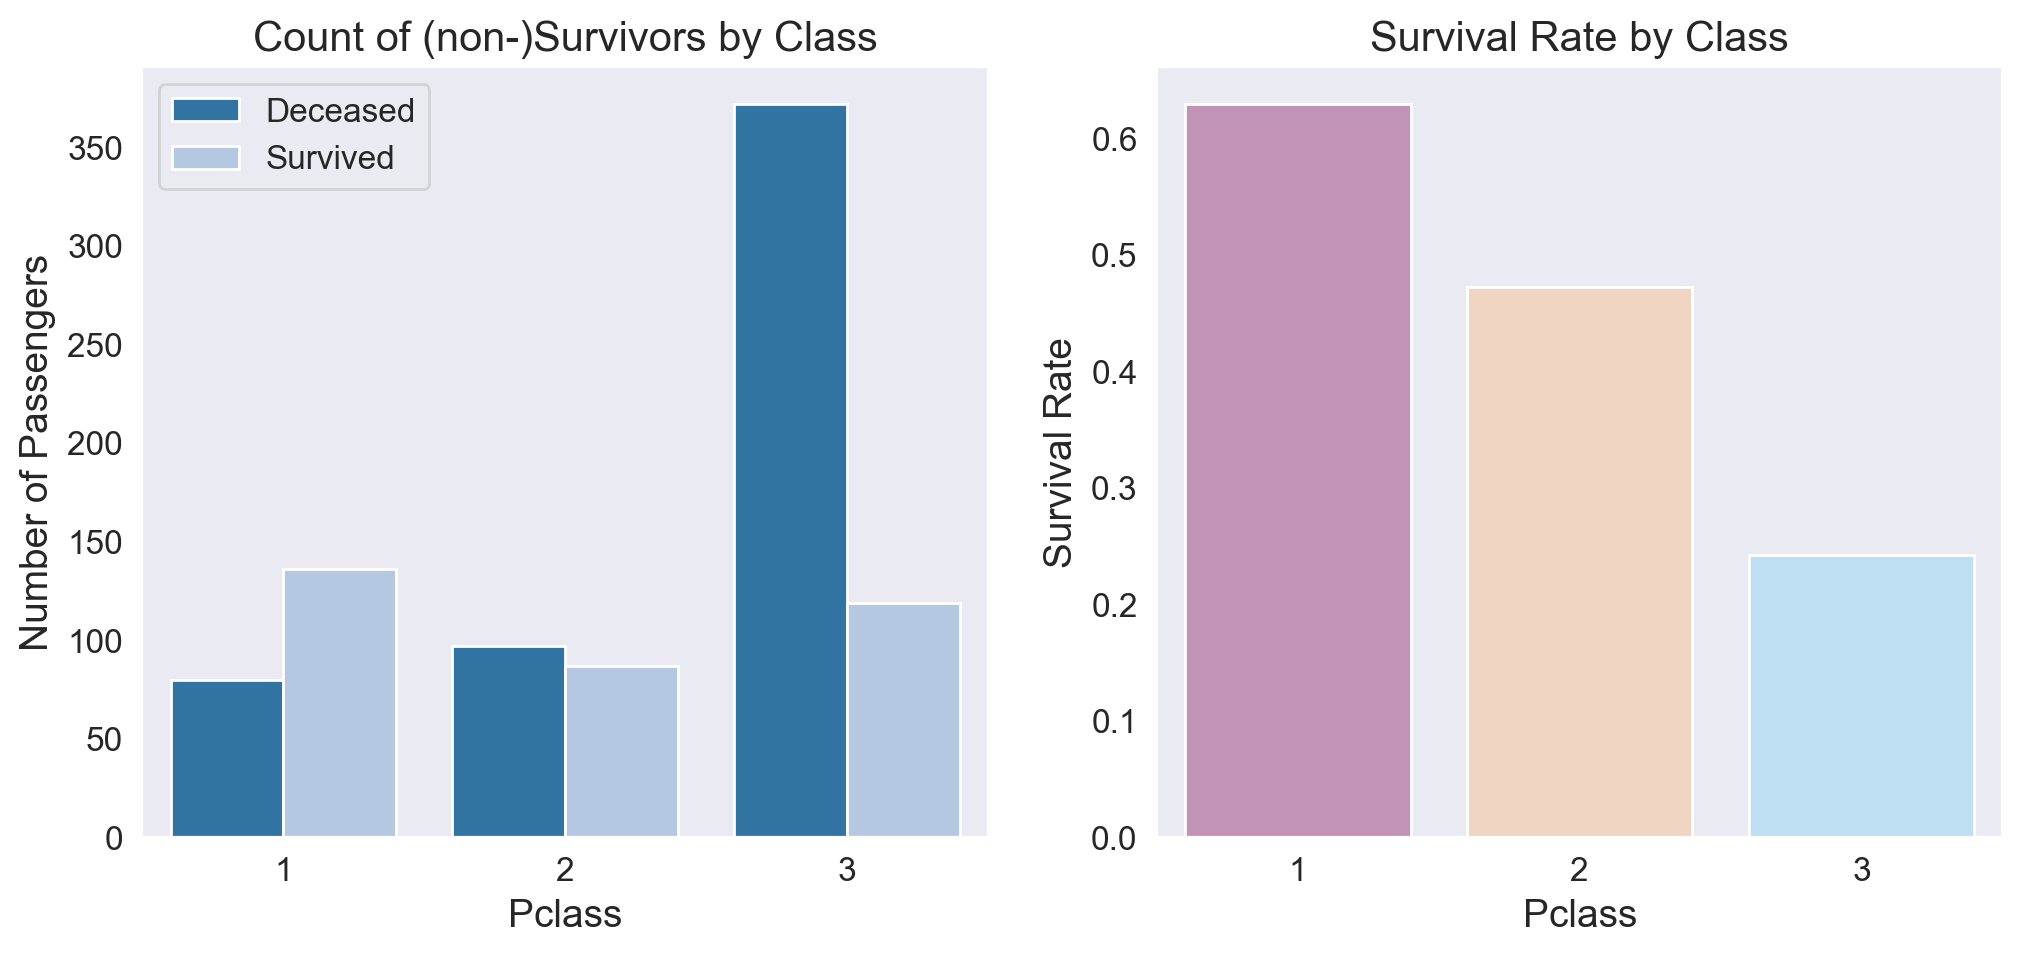

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.countplot(x = 'Pclass', hue = 'Survived', data = train_df,  palette = 'tab20', ax = ax1) 
ax1.legend(['Deceased', 'Survived'])
ax1.set_title('Count of (non-)Survivors by Class')
ax1.set_ylabel('Number of Passengers')

sns.barplot(x = 'Pclass', y = 'Survived', data = train_df,  palette = ['#C98BB9', '#F7D4BC', '#B5E2FA'], ci = None, ax = ax2)
ax2.set_title('Survival Rate by Class')
ax2.set_ylabel('Survival Rate');

50% 이상의 승객이 3등석에 탑승했습니다. 그럼에도 불구하고 오른쪽 그래프에서 보듯이 **부유한** 승객이 **생존**에 유리했습니다 (3등석에서 1등석으로 갈수록 생존률이 증가합니다).

**가족 동반 여부 분석**: SibSp(형제/배우자 수)와 Parch(부모/자녀 수)를 사용하여 혼자 탑승한 승객과 가족과 함께 탑승한 승객을 분리합니다. 불리언 조건으로 필터링합니다.

## 5. 요금 (Fare)

요금은 등급과 밀접한 관련이 있다고 가정할 수 있습니다. 등급별 요금 분포의 박스플롯과 생존 여부별 히스토그램을 그려보겠습니다:

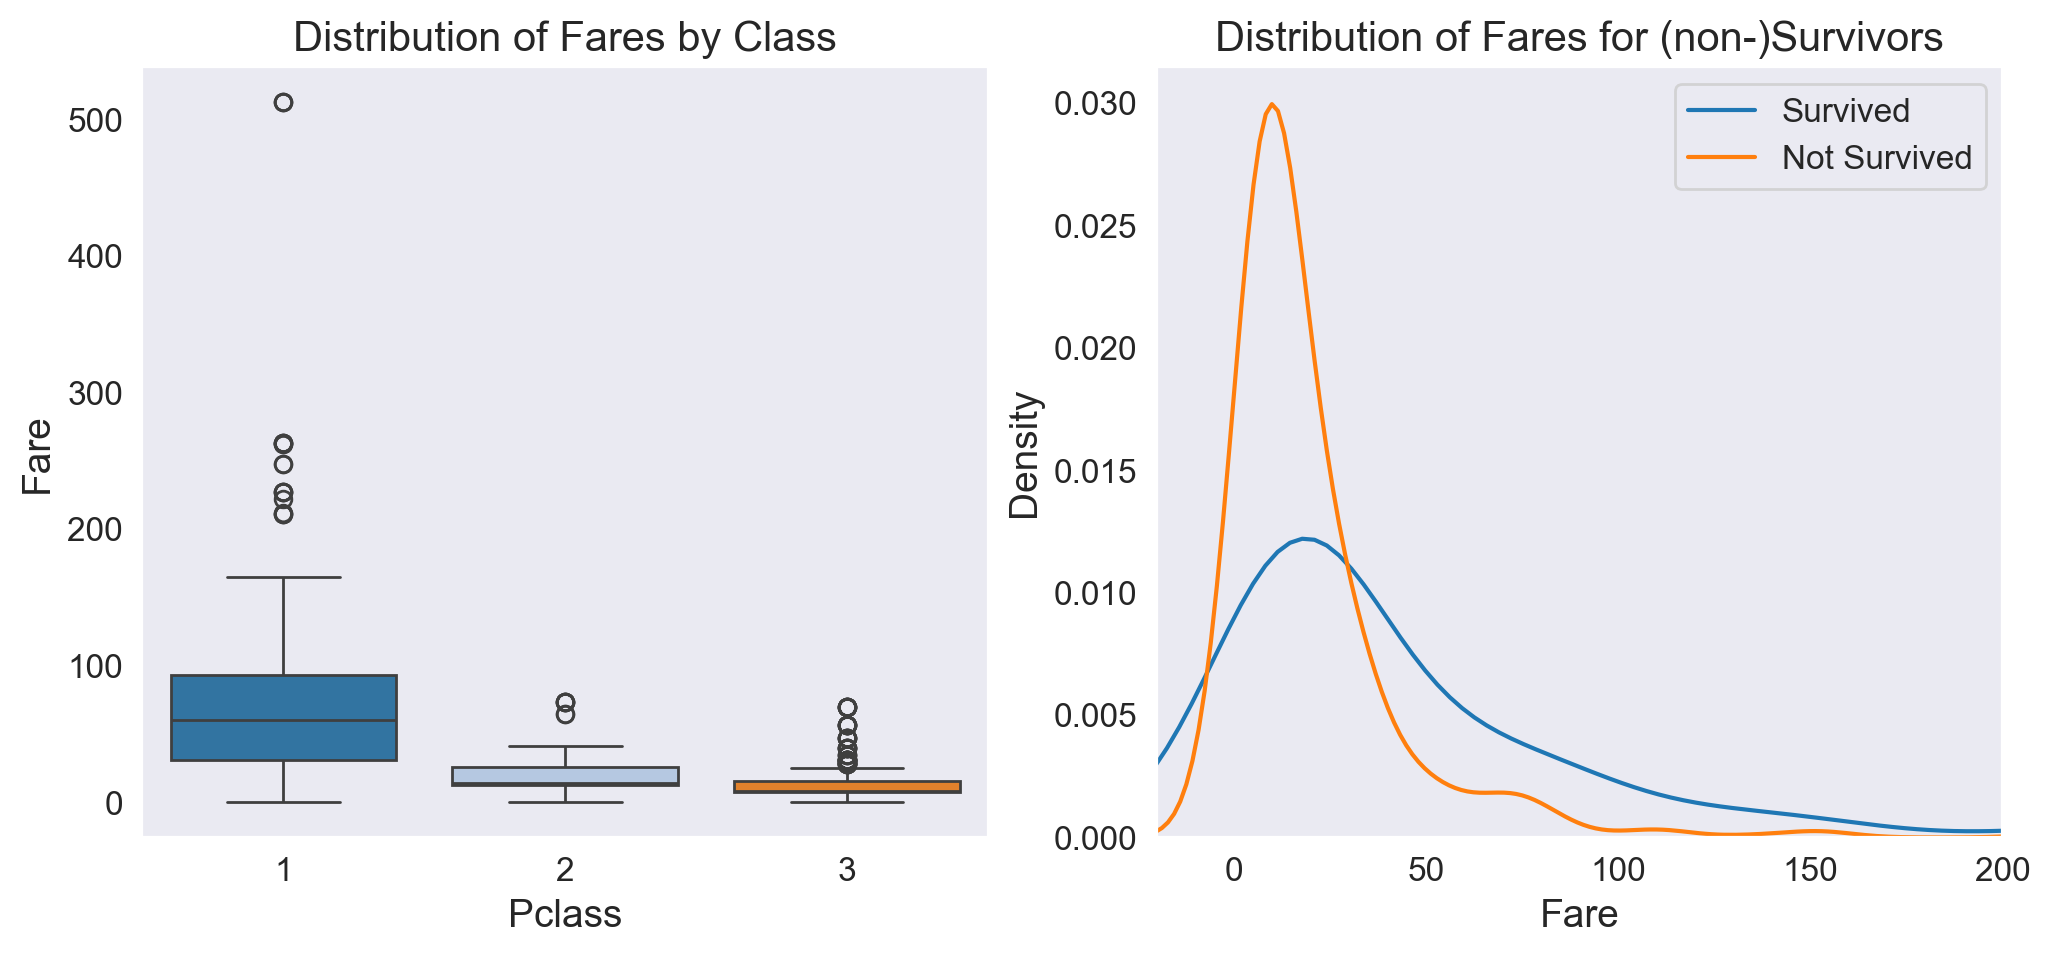

In [38]:
# 요금 분포 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.boxplot(x = 'Pclass', y = 'Fare', data = train_df, palette = 'tab20', ax = ax1)
ax1.set_title('Distribution of Fares by Class')

# seaborn 0.11+에서 distplot은 deprecated됨 → histplot 또는 kdeplot 사용
sns.kdeplot(train_df[train_df['Survived'] == 1]['Fare'], label = 'Survived', ax = ax2)
sns.kdeplot(train_df[train_df['Survived'] == 0]['Fare'], label = 'Not Survived', ax = ax2)
ax2.set_title('Distribution of Fares for (non-)Survivors')
ax2.set_xlim([-20, 200])
ax2.legend();

1등석 승객이 다른 등급보다 더 높은 요금을 지불한 것은 놀랍지 않습니다. 등급 비교에서 이미 확인했듯이, **높은 요금**은 **높은 생존 확률**로 이어집니다.

'Age'와 마찬가지로 요금 값을 **구간화(binning)**하면 유용합니다. 이 속성에는 5개의 분위수 기반 이산화를 사용하겠습니다.

**친척 수 Feature Engineering**: SibSp + Parch로 새로운 'Relatives' 특성을 생성합니다. `catplot`으로 친척 수와 생존률의 관계를 시각화합니다. 1-3명의 친척이 있을 때 생존률이 가장 높습니다.

In [39]:
train_df['Fare_Bin'] = pd.qcut(train_df['Fare'], 5)
# pandas 2.0+에서는 numeric_only=True 명시
train_df[['Fare_Bin', 'Survived']].groupby(['Fare_Bin']).mean(numeric_only=True)

,Survived
Fare_Bin,
"(-0.001, 7.854]",0.218
"(7.854, 10.5]",0.201
"(10.5, 21.679]",0.424
"(21.679, 39.688]",0.444
"(39.688, 512.329]",0.642




## 6. SibSp와 Parch (형제/배우자 및 부모/자녀)

친척이 있으면 승객의 생존 확률에 영향을 줄 수 있다고 주장할 수 있습니다. 테스트해보겠습니다:

**호칭(Title) 추출**: 이름에서 호칭을 추출하는 Feature Engineering입니다. `split(',')`으로 성을 분리하고, `split('.')`으로 호칭을 추출합니다. 드문 호칭(Don, Dr 등)은 'Rare Title'로 통합합니다.

In [40]:
alone = train_df[(train_df['SibSp'] == 0) & (train_df['Parch'] == 0)]
not_alone = train_df[(train_df['SibSp'] != 0) | (train_df['Parch'] != 0)]

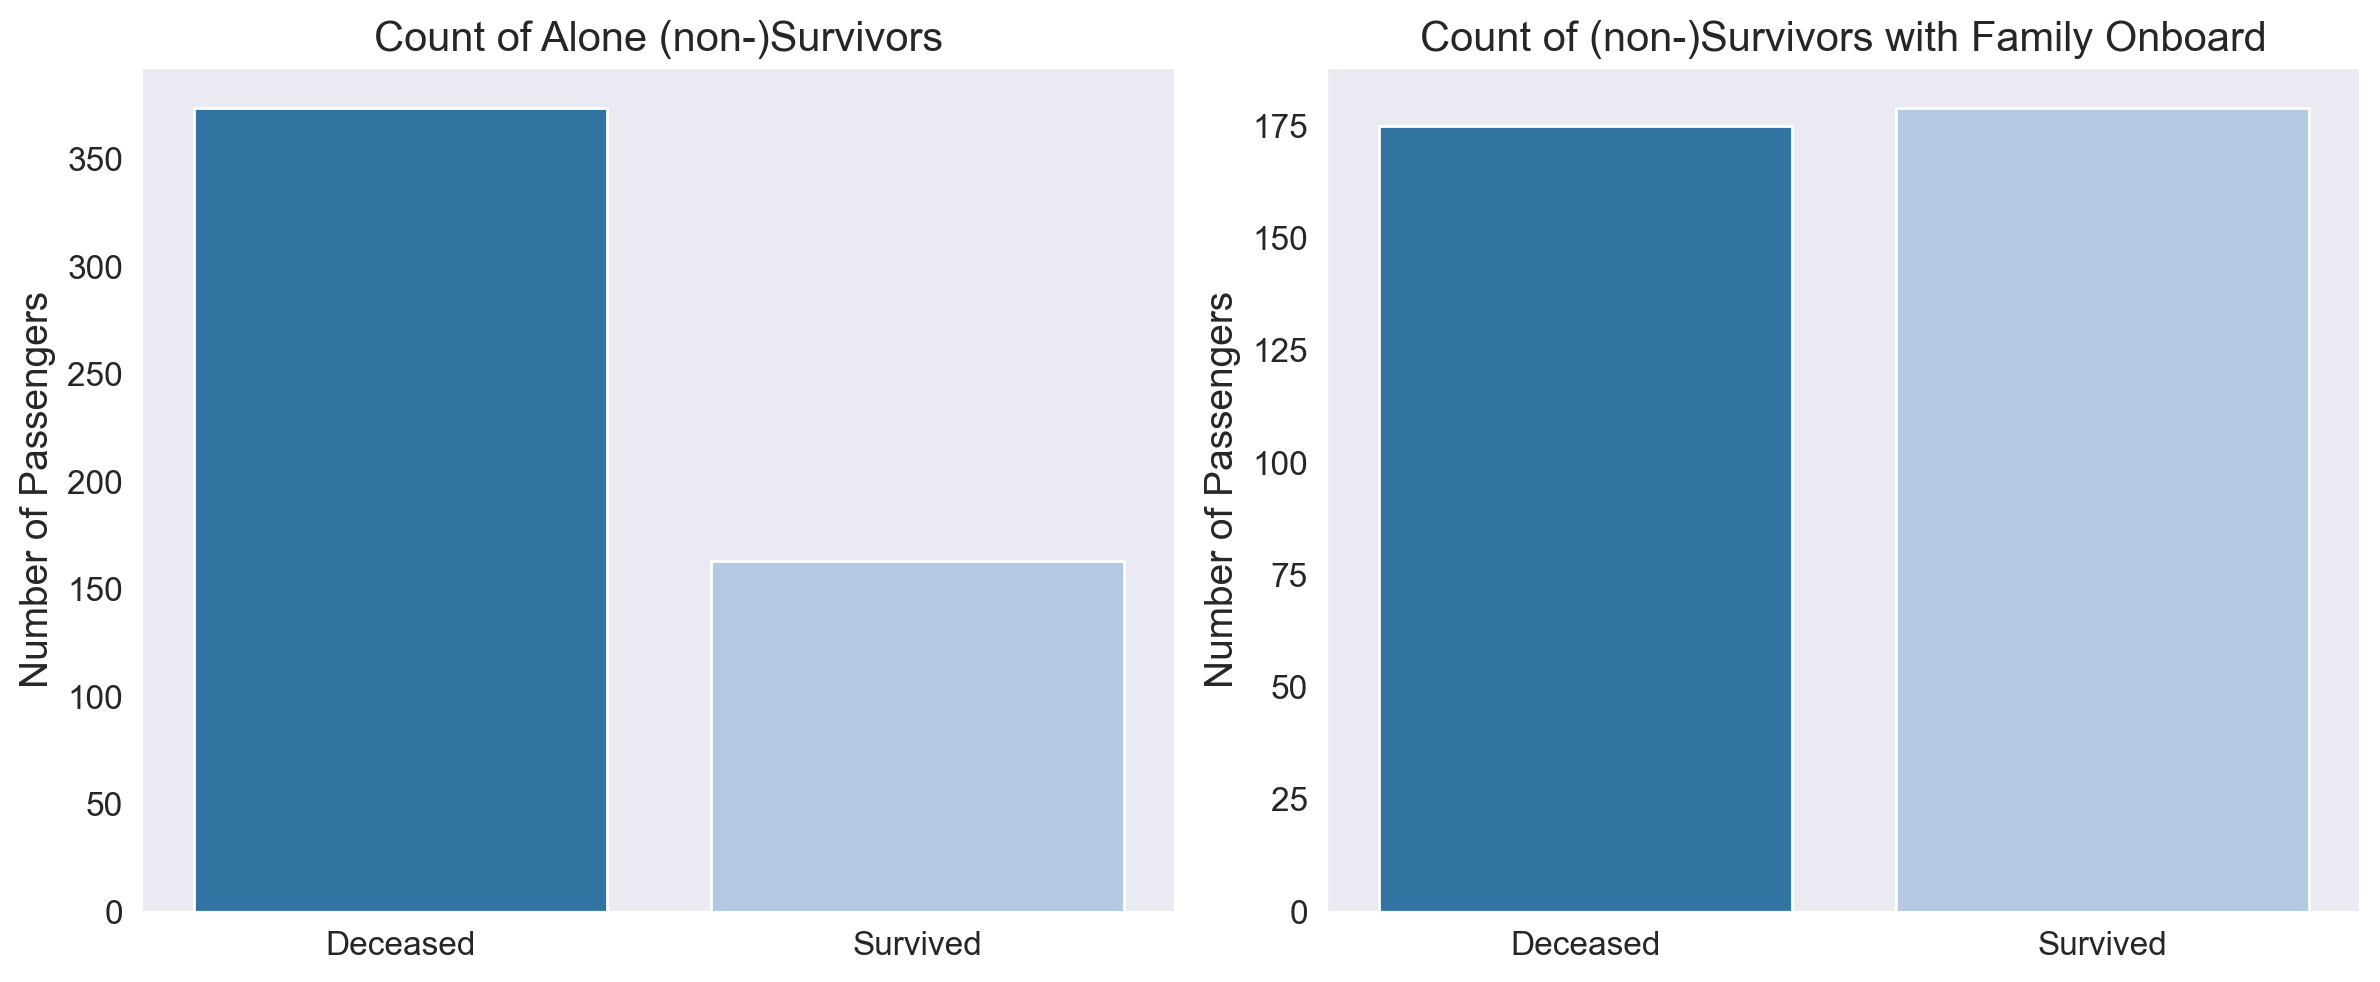

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.countplot(x = 'Survived', data = alone,  palette = 'tab20', ax = ax1) 
ax1.set_title('Count of Alone (non-)Survivors')
ax1.set_xlabel('')
ax1.set_xticklabels(['Deceased', 'Survived'])
ax1.set_ylabel('Number of Passengers')

sns.countplot(x = 'Survived', data = not_alone,  palette = 'tab20', ax = ax2) 
ax2.set_title('Count of (non-)Survivors with Family Onboard')
ax2.set_xlabel('')
ax2.set_xticklabels(['Deceased', 'Survived'])
ax2.set_ylabel('Number of Passengers')

plt.tight_layout();

배에 **친척**이 있으면 **생존 확률이 높아집니다**.

친척의 수가 중요할까요? 배에 탑승한 친척 수에 대한 새로운 속성을 만들어 테스트해보겠습니다:

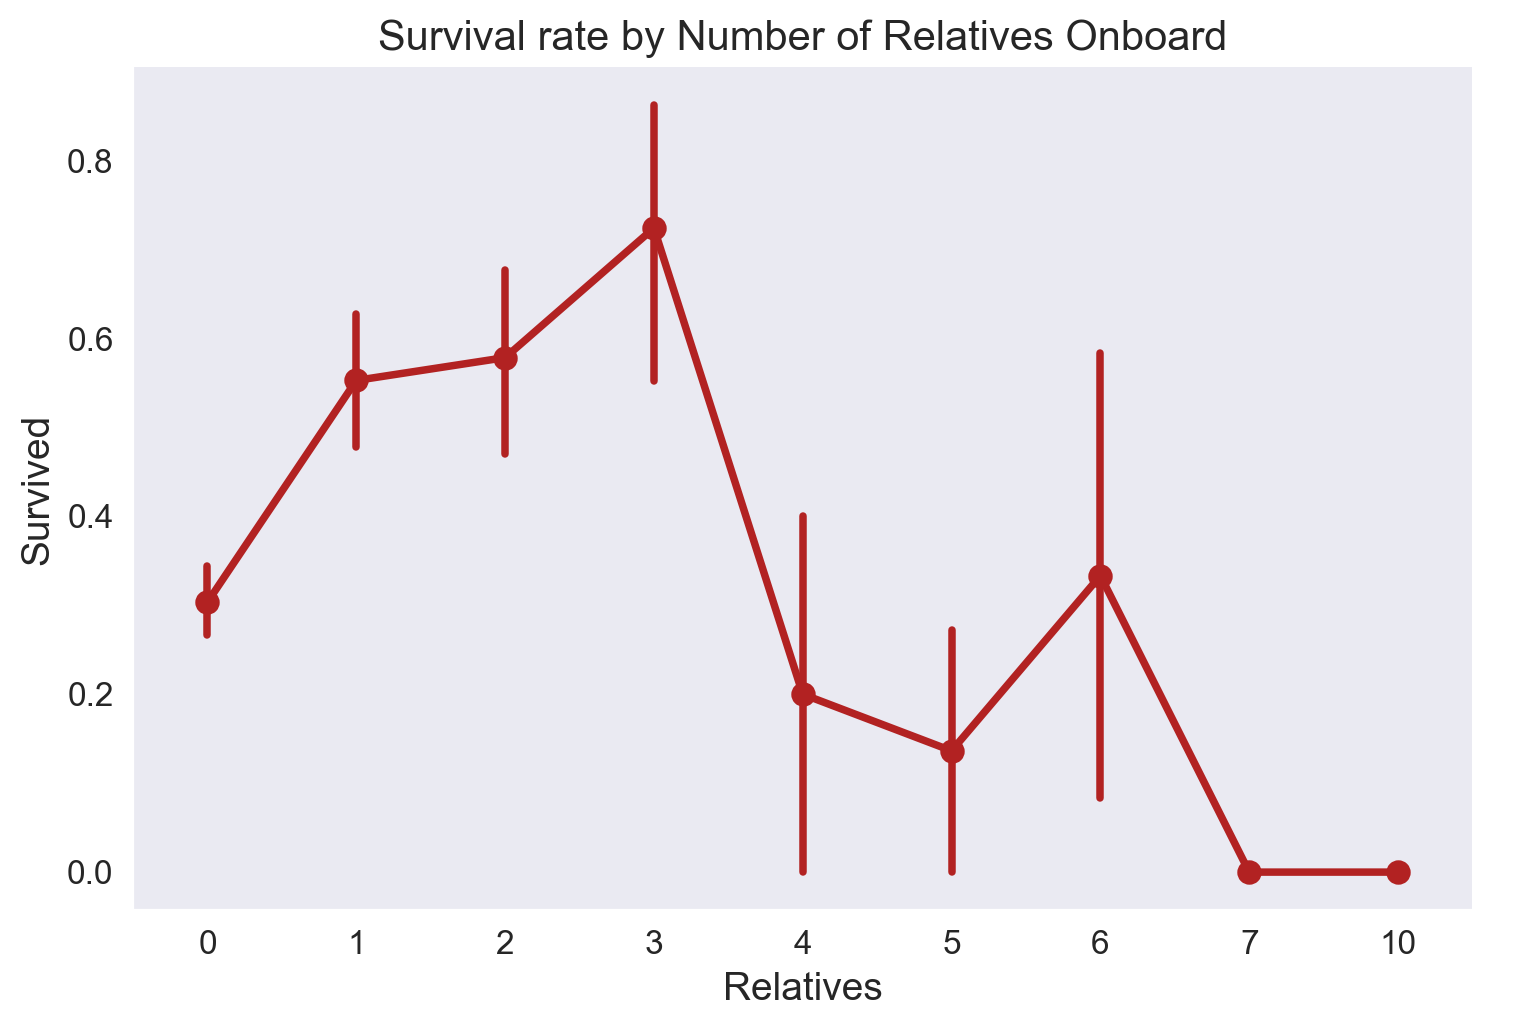

In [42]:
# 친척 수에 따른 생존률 시각화
train_df['Relatives'] = train_df['SibSp'] + train_df['Parch']

# seaborn 0.9+에서 factorplot은 deprecated됨 → catplot 사용
sns.catplot(x='Relatives', y='Survived', data = train_df, kind='point', color = 'firebrick', aspect = 1.5)
plt.title('Survival rate by Number of Relatives Onboard');

1~3명의 친척이 있으면 실제로 생존 확률이 높아집니다.

## 7. 이름/호칭 (Name/Title)

마지막으로 호칭(Mr, Miss 등)이 생존에 영향을 미치는지 확인해보겠습니다. Ken의 [코드](https://www.kaggle.com/kenjee/titanic-project-example)를 사용하여 각 인스턴스의 호칭을 추출했습니다. 그런 다음 드문 호칭을 더 일반적인 것으로 대체했습니다.

In [43]:
train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

train_df['Title'].replace({'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss'}, inplace = True)
train_df['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess', 'Jonkheer'],
                           'Rare Title', inplace = True)
train_df['Title'].value_counts()

Title
Mr            517
Miss          185
Mrs           126
Master         40
Rare Title     23
Name: count, dtype: int64

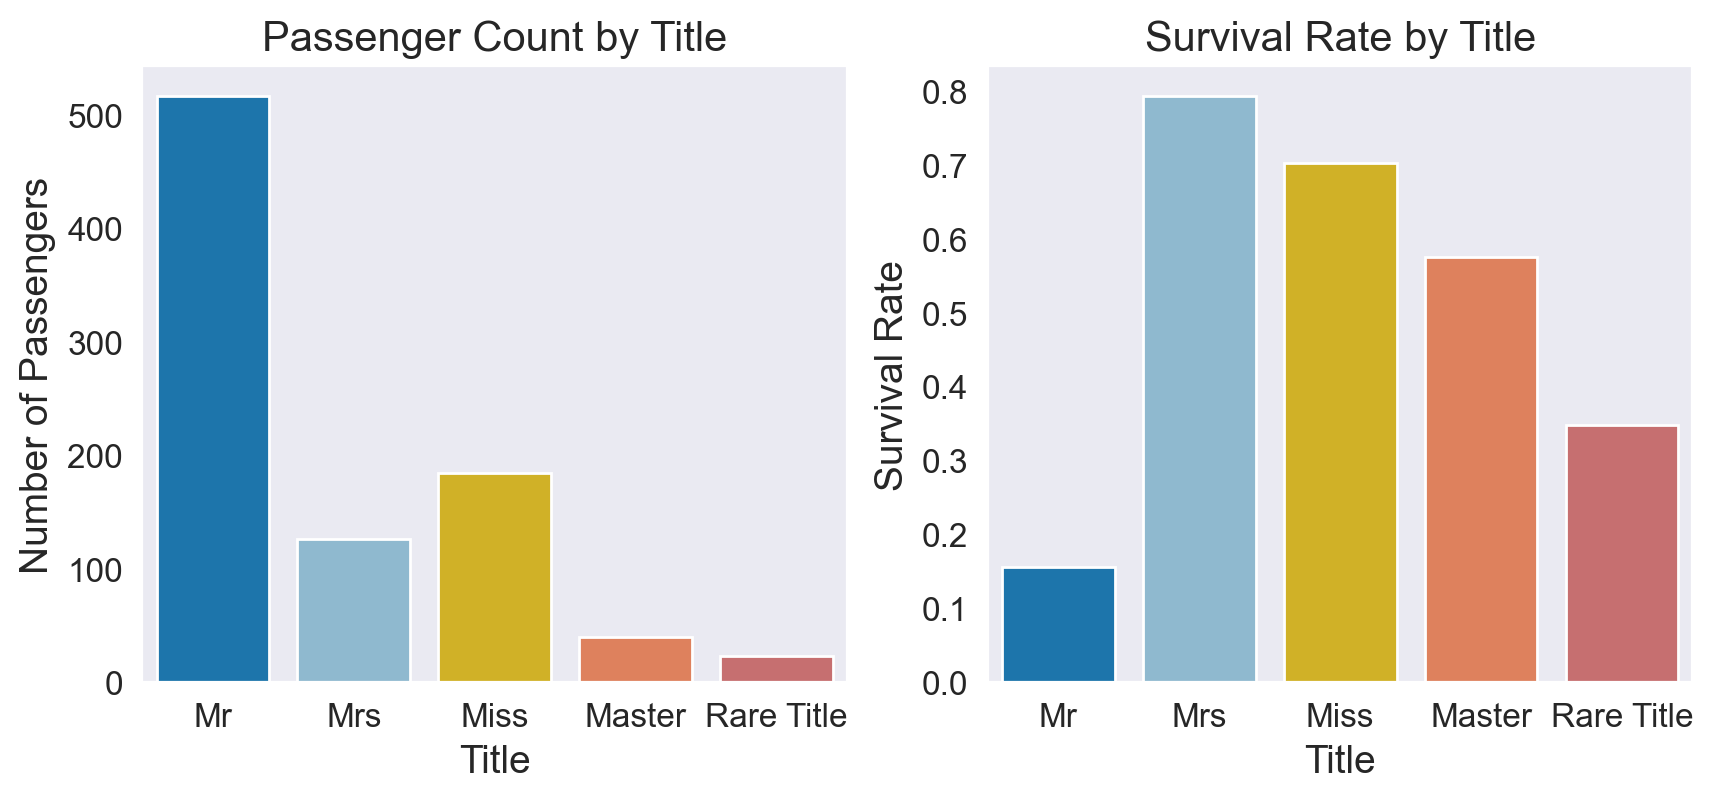

In [44]:
cols = ['#067BC2', '#84BCDA', '#ECC30B', '#F37748', '#D56062']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

sns.countplot(x = 'Title', data = train_df,  palette = cols, ax = ax1)
ax1.set_title('Passenger Count by Title')
ax1.set_ylabel('Number of Passengers')

sns.barplot(x = 'Title', y = 'Survived', data = train_df,  palette = cols, ci = None, ax = ax2)
ax2.set_title('Survival Rate by Title')
ax2.set_ylabel('Survival Rate');

여성(Mrs 또는 Miss)의 생존 확률이 더 높다는 것은 이미 언급했습니다. 정말 흥미로운 것은 **Master**와 **희귀 호칭**을 가진 사람들이 일반 남성(Mr)에 비해 실제로 **생존 확률이 더 높다**는 것입니다.

## 8. 기타

### 객실 (Cabin)

앞서 확인했듯이 훈련 세트의 4개 중 3개 인스턴스에서 'Cabin' 값이 누락되어 있습니다. 또한 존재하는 (NaN이 아닌) 값들 중에서도 고유 값의 수가 많습니다:

In [45]:
print ('Cabin:\n  Number of existing values: ', train_df['Cabin'].notnull().sum())
print ('    Number of unique values: ', train_df['Cabin'].nunique())

Cabin:
  Number of existing values:  204
    Number of unique values:  147


따라서 안전하게 제거할 수 있습니다. 'Cabin' 특성에 대한 자세한 정보는 이 [노트북](https://www.kaggle.com/ccastleberry/titanic-cabin-features)을 참조하세요.

### 티켓/가족 생존 (Ticket/Family Survival)

'Ticket' 속성을 간접적으로 사용하여 'Family_Survival'이라는 새로운 특성을 만들겠습니다. 이 아이디어는 S.Xu의 [커널](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever)에서 가져왔으며, 같은 티켓을 가진 가족과 사람들을 그룹화하고 이를 기반으로 정보를 검색합니다. 더 깔끔한 버전의 코드는 Konstantin의 [커널](https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/notebook)에서 가져왔습니다 (다음 섹션 참조).

## 9. 요약


|      속성      | 중요 여부 |            처리 방법           |
|:-------------------:|:---------:|:---------------------------:|
|     PassengerId     |     아니오    |           제거           |
|         Sex         |    예    |            인코딩           |
|         Age         |    예    |        구간화 및 인코딩       |
| 승선 항구 (Embarked) |     아니오    |           제거           |
|        Pclass       |    예    |              -              |
|         Fare        |    예    |        구간화 및 인코딩       |
|   SibSp와 Parch   |    예    |     'Relatives' 생성    |
|         Name        |    예    | 'Title' 생성 및 인코딩 |
|        Cabin        |     아니오    |           제거           |
|        Ticket       |    예    |  'Family_Survival' 생성 |

# 데이터 준비

이 섹션에서는 머신러닝 알고리즘을 구축하기 전에 데이터프레임을 준비합니다. 결합된 데이터프레임을 사용하여 훈련 세트와 테스트 세트를 동시에 처리합니다. 대안으로 파이프라인을 사용할 수도 있습니다.

단계:

1) 'Age'와 'Fare'의 결측값을 훈련 세트의 해당 중앙값으로 대체합니다. 테스트 세트에는 'Fare'의 결측값이 하나 있습니다 (test_df.isnull().sum()으로 쉽게 확인할 수 있습니다).

In [46]:
# 결측치를 median값으로 채운다.
all_data['Age'] = all_data['Age'].fillna(train_df['Age'].median())
all_data['Fare'] = all_data['Fare'].fillna(train_df['Fare'].median())
print ('Done!')

Done!


2) 새로운 속성('Family_Survival', 'Age_Bin', 'Fare_Bin', 'Relatives', 'Title')을 추가합니다.

**결측치 처리**: `fillna()`로 Age와 Fare의 결측치를 중앙값(median)으로 대체합니다. 중앙값은 이상치(outlier)에 덜 민감하여 평균보다 적합합니다.

In [47]:
# Again, the code for 'Family_Survival' comes from this kernel:
# https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/notebook

all_data['Last_Name'] = all_data['Name'].apply(lambda x: str.split(x, ',')[0])
all_data['Fare'].fillna(all_data['Fare'].mean(), inplace = True)

default_sr_value = 0.5
all_data['Family_Survival'] = default_sr_value

In [48]:
all_data['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
413                                   Spector, Mr. Woolf
414                         Oliva y Ocana, Dona. Fermina
415                         Saether, Mr. Simon Sivertsen
416                                  Ware, Mr. Frederick
417                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

**Family_Survival Feature Engineering**: 같은 성과 요금을 가진 가족 그룹을 찾아, 가족 중 생존자가 있으면 1, 모두 사망했으면 0, 정보가 없으면 0.5를 할당합니다. 이 특성은 같은 티켓을 가진 그룹에 대해서도 반복 적용됩니다.

In [49]:
all_data['Last_Name']

0             Braund
1            Cumings
2          Heikkinen
3           Futrelle
4              Allen
           ...      
413          Spector
414    Oliva y Ocana
415          Saether
416             Ware
417            Peter
Name: Last_Name, Length: 1309, dtype: object

In [50]:
df = all_data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId', 'SibSp', 'Parch', 'Age', 'Cabin']]
df.head()

,Survived,Name,Last_Name,Fare,Ticket,PassengerId,SibSp,Parch,Age,Cabin
0,0.0,"Braund, Mr. Owen Harris",Braund,7.250,A/5 21171,1,1,0,22.0,NaN
1,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,71.283,PC 17599,2,1,0,38.0,C85
2,1.0,"Heikkinen, Miss. Laina",Heikkinen,7.925,STON/O2. 3101282,3,0,0,26.0,NaN
3,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,53.100,113803,4,1,0,35.0,C123
4,0.0,"Allen, Mr. William Henry",Allen,8.050,373450,5,0,0,35.0,NaN


In [51]:
# 그룹화: groupby(['Last_Name', 'Fare'])로 같은 성(Last_Name)과 같은 요금(Fare)을 가진 승객들을 가족으로 그룹화

for grp, grp_df in all_data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId', 'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):

    # 가족 그룹 식별: len(grp_df) != 1 - 그룹에 2명 이상이 있으면 가족으로 판단
    if (len(grp_df) != 1):  # A Family group is found.
        for ind, row in grp_df.iterrows():
            # grp_df.drop(ind) - 현재 승객을 제외한 나머지 가족 구성원만 선택
            # smax - 나머지 가족 중 생존자가 있는지 (최댓값)
            smax = grp_df.drop(ind)['Survived'].max()
            # smin - 나머지 가족이 모두 사망했는지 (최솟값)
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            
            if (smax == 1.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0



In [52]:
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Family_Survival
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S,Braund,0.5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C,Cumings,0.5
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S,Heikkinen,0.5
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S,Futrelle,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S,Allen,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.050,NaN,S,Spector,0.5
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900,C105,C,Oliva y Ocana,0.5
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.250,NaN,S,Saether,0.5
416,1308,NaN,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.050,NaN,S,Ware,0.5


In [53]:
for _, grp_df in all_data.groupby('Ticket'):
    
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                
                if (smax == 1.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0

In [54]:
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Family_Survival
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S,Braund,0.5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C,Cumings,0.5
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S,Heikkinen,0.5
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S,Futrelle,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S,Allen,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.050,NaN,S,Spector,0.5
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900,C105,C,Oliva y Ocana,1.0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.250,NaN,S,Saether,0.5
416,1308,NaN,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.050,NaN,S,Ware,0.5


In [55]:
#####################################################################################
all_data['Age_Bin'] = (all_data['Age']//15)*15
all_data['Fare_Bin'] = pd.qcut(all_data['Fare'], 5)
all_data['Relatives'] = all_data['SibSp'] + all_data['Parch']
#####################################################################################
all_data['Title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'}, inplace = True)
all_data['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona'],
                           'Rare Title', inplace = True)    

print ('Done!')

Done!


In [56]:
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Family_Survival,Age_Bin,Fare_Bin,Relatives,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S,Braund,0.5,15.0,"(-0.001, 7.854]",1,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C,Cumings,0.5,30.0,"(41.579, 512.329]",1,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S,Heikkinen,0.5,15.0,"(7.854, 10.5]",0,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S,Futrelle,0.0,30.0,"(41.579, 512.329]",1,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S,Allen,0.5,30.0,"(7.854, 10.5]",0,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.050,NaN,S,Spector,0.5,15.0,"(7.854, 10.5]",0,Mr
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900,C105,C,Oliva y Ocana,1.0,30.0,"(41.579, 512.329]",0,Rare Title
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.250,NaN,S,Saether,0.5,30.0,"(-0.001, 7.854]",0,Mr
416,1308,NaN,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.050,NaN,S,Ware,0.5,15.0,"(7.854, 10.5]",0,Mr


3) scikit-learn의 `LabelEncoder()`를 사용하여 'Fare_Bin', 'Age_Bin', 'Title', 'Sex'를 인코딩합니다.

**Feature Engineering 종합**: Age_Bin(나이 구간화), Fare_Bin(요금 분위수 구간화), Relatives(친척 수), Title(호칭) 등 새로운 특성들을 생성합니다. 이는 모델 성능 향상에 중요한 역할을 합니다.

In [57]:
all_data['Fare_Bin'] = LabelEncoder().fit_transform(all_data['Fare_Bin'])
all_data['Age_Bin'] = LabelEncoder().fit_transform(all_data['Age_Bin'])
all_data['Title_Bin'] = LabelEncoder().fit_transform(all_data['Title'])
all_data['Sex'] = LabelEncoder().fit_transform(all_data['Sex'])

print ('Done!')

Done!


In [58]:
all_data['Fare_Bin']

0      0
1      4
2      1
3      4
4      1
      ..
413    1
414    4
415    0
416    1
417    3
Name: Fare_Bin, Length: 1309, dtype: int64

**레이블 인코딩**: `LabelEncoder()`로 범주형 변수(Fare_Bin, Age_Bin, Title, Sex)를 숫자로 변환합니다. 머신러닝 알고리즘은 숫자 데이터만 처리할 수 있으므로 이 변환이 필요합니다.

4) 불필요한 모든 속성을 제거합니다.

In [59]:
# EDA를 한후에 예측하는데 있어서 불필요 항목 drop
all_data.drop(['PassengerId', 'Age', 'Fare', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Title', 'Last_Name', 'Embarked'], axis = 1, inplace = True)

print ('Done!')
print ('Modified dataset: ')
all_data.head()

Done!
Modified dataset: 


,Survived,Pclass,Sex,Family_Survival,Age_Bin,Fare_Bin,Relatives,Title_Bin
0,0.0,3,1,0.5,1,0,1,2
1,1.0,1,0,0.5,2,4,1,3
2,1.0,3,0,0.5,1,1,0,1
3,1.0,1,0,0.0,2,4,1,3
4,0.0,3,1,0.5,2,1,0,2


5) 결합된 데이터셋을 훈련 세트와 테스트 세트로 분리하고 각 특성 벡터를 스케일링합니다.

In [60]:
# train.csv, test.csv를 불러와서 concat후에 다시 분리

train_df = all_data[:891]

# 학습시에 label과 학습해야할 feature를 분리
X_train = train_df.drop('Survived', axis=1)
y_train = train_df['Survived']

#######################################################

test_df = all_data[891:]

X_test = test_df.copy()
X_test.drop('Survived', axis=1, inplace=True)
print ('Splitting: Done!')

Splitting: Done!


**데이터 분리**: 결합했던 데이터를 다시 훈련/테스트 세트로 분리합니다. `X_train`(특성), `y_train`(타겟/레이블)로 나누어 지도학습에 사용합니다.

In [61]:
std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)  # fit_transform the X_train
X_test_scaled = std_scaler.transform(X_test)        # only transform the X_test

print ('Scaling: Done!')

Scaling: Done!


**표준화(Standardization)**: `StandardScaler()`로 특성을 평균=0, 표준편차=1로 변환합니다. 훈련 데이터에는 `fit_transform()`, 테스트 데이터에는 `transform()`만 적용하여 데이터 누수(leakage)를 방지합니다.

# 머신러닝 모델 구축

## 베이스라인 모델

이 하위 섹션의 목표는 훈련 세트에서 8개의 서로 다른 추정기/분류기의 **베이스라인 성능**을 계산하는 것입니다. 이를 통해 나중에 튜닝이 각 모델을 어떻게 개선하는지 확인할 수 있습니다.

분류기 목록:

1) 가우시안 나이브 베이즈 (Gaussian Naive Bayes), <br>
2) 로지스틱 회귀 (Logistic Regression), <br>
3) K-최근접 이웃 분류기 (K-Nearest Neighbor Classifier), <br>
4) 서포트 벡터 분류기 (Support Vector Classifier), <br>
5) 결정 트리 분류기 (Decision Tree Classifier), <br>
6) 랜덤 포레스트 분류기 (Random Forest Classifier), <br>
7) XGBoost 분류기 (Xtreme Gradient Boosting Classifier), <br>
8) AdaBoost 분류기

이 분류기들이 어떻게 작동하는지에 대한 자세한 내용은 다루지 않겠습니다. 이 훌륭한 [책](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)에서 더 자세히 읽을 수 있습니다.

베이스라인 모델의 경우 **기본 파라미터**를 사용하고 **k-fold 교차 검증**을 수행하여 (평균) 정확도를 평가합니다.

아래 그림에 설명된 k-fold 교차 검증의 아이디어는 간단합니다:
(훈련) 세트를 k개의 부분집합/폴드로 나누고, k-1개의 폴드를 사용하여 모델을 훈련시킨 다음 나머지 한 폴드에서 모델을 평가합니다. 이 과정은 모든 폴드가 한 번씩 테스트될 때까지 반복됩니다.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width = 400>
<center> scikit-learn 공식 문서에서 가져옴 </center>

<br>

[scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)의 `cross_val_score()` 메서드를 사용하여 교차 검증을 구현할 수 있습니다. k = 5 폴드를 사용합니다.

**베이스라인 모델 평가**: 8개의 분류 알고리즘을 기본 파라미터로 5-fold 교차 검증합니다. `cross_val_score()`는 데이터를 5개로 나누어 각각 테스트하고 평균 정확도를 반환합니다. `n_jobs=-1`은 모든 CPU 코어를 사용합니다.

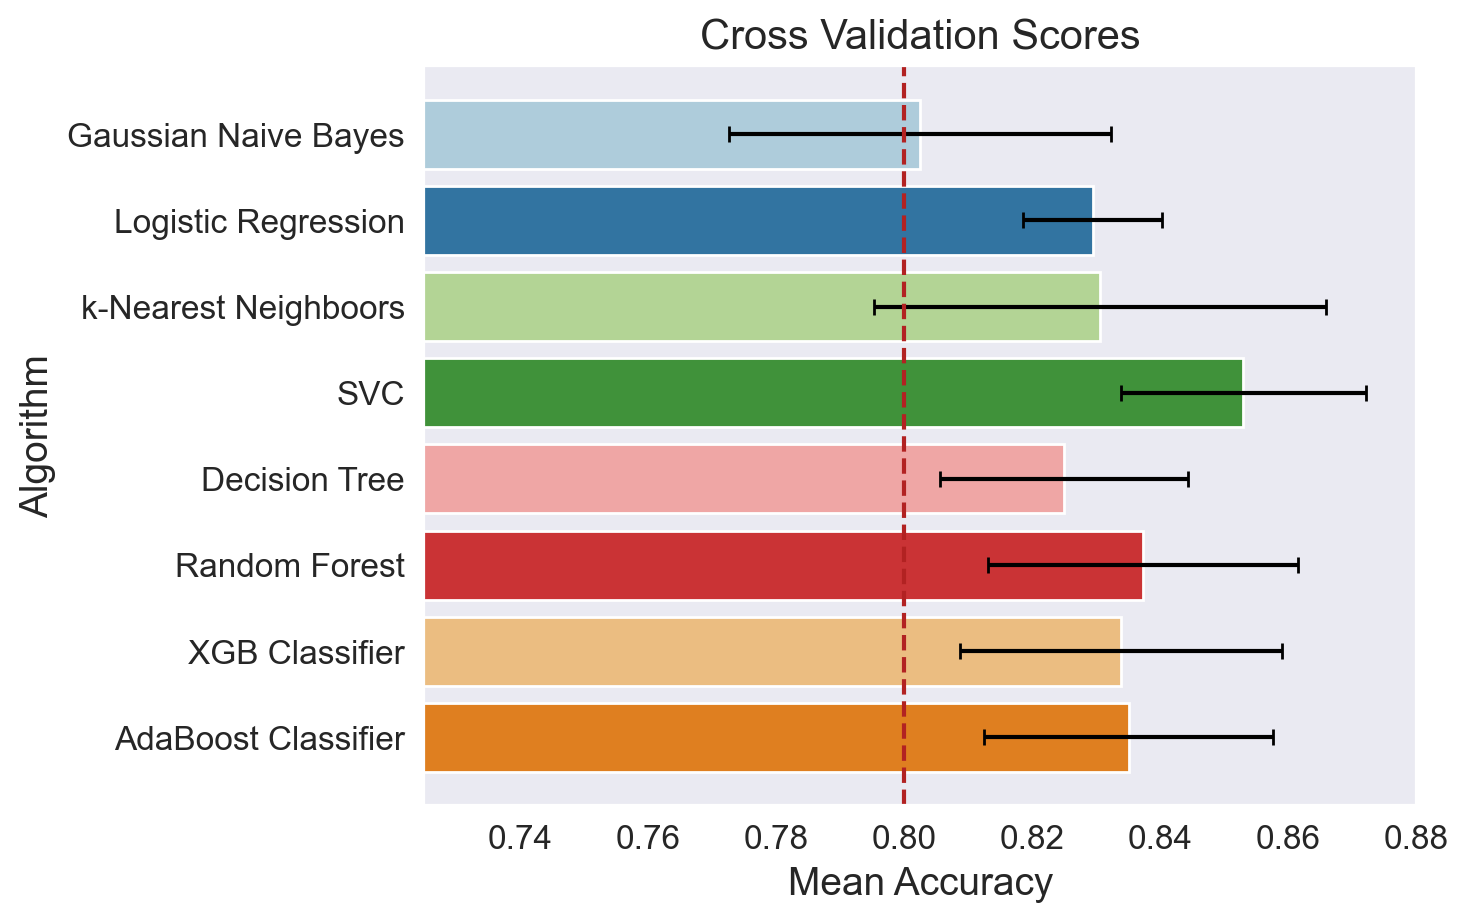

In [62]:
random_state = 1

# Step 1: create a list containing all estimators with their default parameters
clf_list = [GaussianNB(), 
            LogisticRegression(random_state = random_state),
            KNeighborsClassifier(), 
            SVC(random_state = random_state, probability = True),
            DecisionTreeClassifier(random_state = random_state), 
            RandomForestClassifier(random_state = random_state),
            XGBClassifier(random_state = random_state), 
            AdaBoostClassifier(estimator = DecisionTreeClassifier(random_state = random_state), random_state = random_state)]


# Step 2: calculate the cv mean and standard deviation for each one of them
cv_base_mean, cv_std = [], []
for clf in clf_list:  
    
    # 데이터셋이 크면 k-fold로 데이터를 나누는것도 시간이 오래걸릴때 cpu를 몇개를 활용할 것인가? 
    # n_jobs = -1 내가 가진 cpu를 모두 활용
    cv = cross_val_score(clf, X_train_scaled, y = y_train, scoring = 'accuracy', cv = 5, n_jobs = -1)
    
    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

    
# Step 3: create a dataframe and plot the mean with error bars
cv_total = pd.DataFrame({'Algorithm': ['Gaussian Naive Bayes', 'Logistic Regression', 'k-Nearest Neighboors', 'SVC', 'Decision Tree', 'Random Forest', 'XGB Classifier', 'AdaBoost Classifier'],
                         'CV-Means': cv_base_mean, 
                         'CV-Errors': cv_std})

# seaborn 최신 버전에서는 x, y 파라미터를 명시적으로 지정해야 함
sns.barplot(x='CV-Means', y='Algorithm', data = cv_total, palette = 'Paired', orient = 'h', errorbar=None)
plt.errorbar(cv_total['CV-Means'], cv_total['Algorithm'], xerr=cv_std, fmt='none', c='black', capsize=3)
plt.xlabel('Mean Accuracy')
plt.title('Cross Validation Scores')
plt.xlim([0.725, 0.88])
plt.axvline(x = 0.80, color = 'firebrick', linestyle = '--');

모든 추정기가 **80% 이상**의 점수를 보이며, SVC가 가장 높은 점수(85%)를 기록했습니다.

이러한 기본 분류기들의 예측을 결합하여 각 개별 분류기보다 더 나은 예측 성능을 얻을 수 있는지 확인할 수 있습니다. 이것이 **앙상블 학습(Ensemble Learning)**의 주요 동기입니다.

두 가지 옵션이 있습니다 ([여기](https://www.oreilly.com/library/view/machine-learning-for/9781783980284/47c32d8b-7b01-4696-8043-3f8472e3a447.xhtml)와 [여기](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/) 참조):<br>
1) **Hard Voting**: 앙상블의 각 추정기 투표를 세고 가장 많은 표를 얻은 클래스를 선택합니다. 즉, 다수결입니다.<br>
2) **Soft Voting**: 각 개별 분류기가 특정 데이터 포인트가 특정 타겟 클래스에 속할 확률 값을 제공합니다. 예측은 분류기의 중요도에 따라 가중되어 합산됩니다. 그런 다음 가중 확률의 합이 가장 큰 타겟 레이블이 투표에서 승리합니다.

**베이스라인 앙상블**: `VotingClassifier`로 여러 모델의 예측을 결합합니다. Hard Voting은 다수결, Soft Voting은 확률 평균을 사용합니다. 개별 모델보다 앙상블이 더 안정적인 성능을 보입니다.

In [63]:
estimators = [('gnb', clf_list[0]), ('lr', clf_list[1]),
              ('knn', clf_list[2]), ('svc', clf_list[3]),
              ('dt', clf_list[4]), ('rf', clf_list[5]),
              ('xgb', clf_list[6]), ('ada', clf_list[7])]

base_voting_hard = VotingClassifier(estimators = estimators , voting = 'hard')
base_voting_soft = VotingClassifier(estimators = estimators , voting = 'soft') 

cv_hard = cross_val_score(base_voting_hard, X_train_scaled, y_train, cv = 5)
cv_soft = cross_val_score(base_voting_soft, X_train_scaled, y_train, cv = 5)

print ('Baseline Models - Ensemble\n--------------------------')
print ('Hard Voting: {}%'.format(np.round(cv_hard.mean()*100, 1)))
print ('Soft Voting: {}%'.format(np.round(cv_soft.mean()*100, 1)))

Baseline Models - Ensemble
--------------------------
Hard Voting: 83.8%
Soft Voting: 84.0%


앙상블은 실제로 대부분의 개별 분류기보다 더 높은 교차 검증(cv) 점수를 보입니다. 일부 분류기를 제거하고 성능이 더 향상되는지 시도해볼 수도 있습니다.

In [64]:
base_voting_hard.fit(X_train_scaled, y_train)
base_voting_soft.fit(X_train_scaled, y_train)

y_pred_base_hard = base_voting_hard.predict(X_test_scaled)
y_pred_base_soft = base_voting_hard.predict(X_test_scaled)

**하이퍼파라미터 튜닝 함수**: `GridSearchCV`의 결과를 출력하는 함수입니다. `best_score_`(최고 교차 검증 점수), `best_params_`(최적 파라미터 조합)을 반환합니다.

## 모델 튜닝

그리드 서치를 사용하여 하이퍼파라미터를 튜닝하고 성능이 향상되는지 확인할 준비가 되었습니다. 하이퍼파라미터에 대한 자세한 정보는 해당 [문서](https://scikit-learn.org/stable/)를 참조하세요.

[Ken](https://www.kaggle.com/kenjee/titanic-project-example)의 커널에서 가져온 간단한 성능 보고 함수를 작성합니다.

In [65]:
cv_means_tuned = [np.nan] # we can't actually tune the GNB classifier, so we fill its element with NaN

#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('-------------------------------')
    print('   Best Score: ' + str(classifier.best_score_))
    print('   Best Parameters: ' + str(classifier.best_params_))
    
    cv_means_tuned.append(classifier.best_score_)

**Logistic Regression 튜닝**: `GridSearchCV`로 최적의 하이퍼파라미터를 찾습니다. `C`(정규화 강도), `penalty`(L1/L2 정규화), `solver`(최적화 알고리즘) 조합을 탐색합니다.

### 로지스틱 회귀 (Logistic Regression)

In [66]:
lr = LogisticRegression()

param_grid = {'max_iter' : [100],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-2, 2, 20),
              'solver' : ['lbfgs', 'liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)

best_clf_lr = clf_lr.fit(X_train_scaled, y_train)
clf_performance(best_clf_lr, 'Logistic Regression')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Logistic Regression
-------------------------------
   Best Score: 0.8361370912058252
   Best Parameters: {'C': np.float64(0.026366508987303583), 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


**KNN 튜닝**: `n_neighbors`(이웃 수), `weights`(가중치 방식), `p`(거리 측정 방식: 1=맨해튼, 2=유클리드) 파라미터를 탐색합니다.

### K-최근접 이웃 (k-Nearest Neighbors)

In [67]:
# n_neighbors = np.concatenate((np.arange(3, 30, 1), np.arange(22, 32, 2)))

knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : np.arange(3, 30, 2),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto'],
              'p': [1, 2]}

clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled, y_train)
clf_performance(best_clf_knn, 'KNN')

Fitting 5 folds for each of 56 candidates, totalling 280 fits
KNN
-------------------------------
   Best Score: 0.8428598330299415
   Best Parameters: {'algorithm': 'auto', 'n_neighbors': np.int64(23), 'p': 1, 'weights': 'uniform'}


**SVC 튜닝**: `kernel`(rbf/linear/poly), `C`(마진 허용도), `gamma`(RBF 커널 계수) 파라미터를 탐색합니다. `probability=True`로 확률 출력을 활성화합니다.

### 서포트 벡터 분류기 (Support Vector Classifier)

In [68]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 
                                  'gamma': [0.01, 0.1, 0.5, 1, 2, 5],
                                  'C': [.1, 1, 2, 5]},
                                 {'kernel': ['linear'], 
                                  'C': [.1, 1, 2, 10]},
                                 {'kernel': ['poly'], 
                                  'degree' : [2, 3, 4, 5], 
                                  'C': [.1, 1, 10]}]

clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled, y_train)
clf_performance(best_clf_svc, 'SVC')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
SVC
-------------------------------
   Best Score: 0.8529470843010483
   Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


**Decision Tree 튜닝**: `max_depth`(트리 최대 깊이), `criterion`(분할 기준: entropy/gini), `min_samples_split`(분할 최소 샘플 수) 파라미터를 탐색합니다.

### 결정 트리 (Decision Tree)

In [69]:
dt = DecisionTreeClassifier(random_state = 1)
param_grid = {'max_depth': [3, 5, 10, 20, 50],
              'criterion': ['entropy', 'gini'],
              'min_samples_split': [5, 10, 15, 30],
              'max_features': [None, 'auto', 'sqrt', 'log2']}
                                  
clf_dt = GridSearchCV(dt, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_dt = clf_dt.fit(X_train_scaled, y_train)
clf_performance(best_clf_dt, 'Decision Tree')

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Decision Tree
-------------------------------
   Best Score: 0.8529345301613207
   Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_split': 10}


**Random Forest 튜닝**: 여러 Decision Tree를 앙상블한 모델입니다. `n_estimators`(트리 개수), `max_depth`, `min_samples_leaf` 등을 탐색합니다.

<br>

랜덤 포레스트, XGBoost, AdaBoost 분류기와 같은 추정기는 각 특성의 **중요도**를 확인할 수 있게 해줍니다.

### 랜덤 포레스트 분류기 (Random Forest Classifier)

**특성 중요도(Feature Importance)**: 트리 기반 모델은 각 특성이 예측에 기여하는 정도를 `feature_importances_` 속성으로 제공합니다. 이를 통해 어떤 특성이 생존 예측에 중요한지 파악할 수 있습니다.

In [70]:
rf = RandomForestClassifier(random_state = 42)
param_grid = {'n_estimators': [50, 150, 300, 450],
              'criterion': ['entropy'],
              'bootstrap': [True],
              'max_depth': [3, 5, 10],
              'max_features': ['auto','sqrt'],
              'min_samples_leaf': [2, 3],
              'min_samples_split': [2, 3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled, y_train)
clf_performance(best_clf_rf, 'Random Forest')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Random Forest
-------------------------------
   Best Score: 0.8518234887954301
   Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


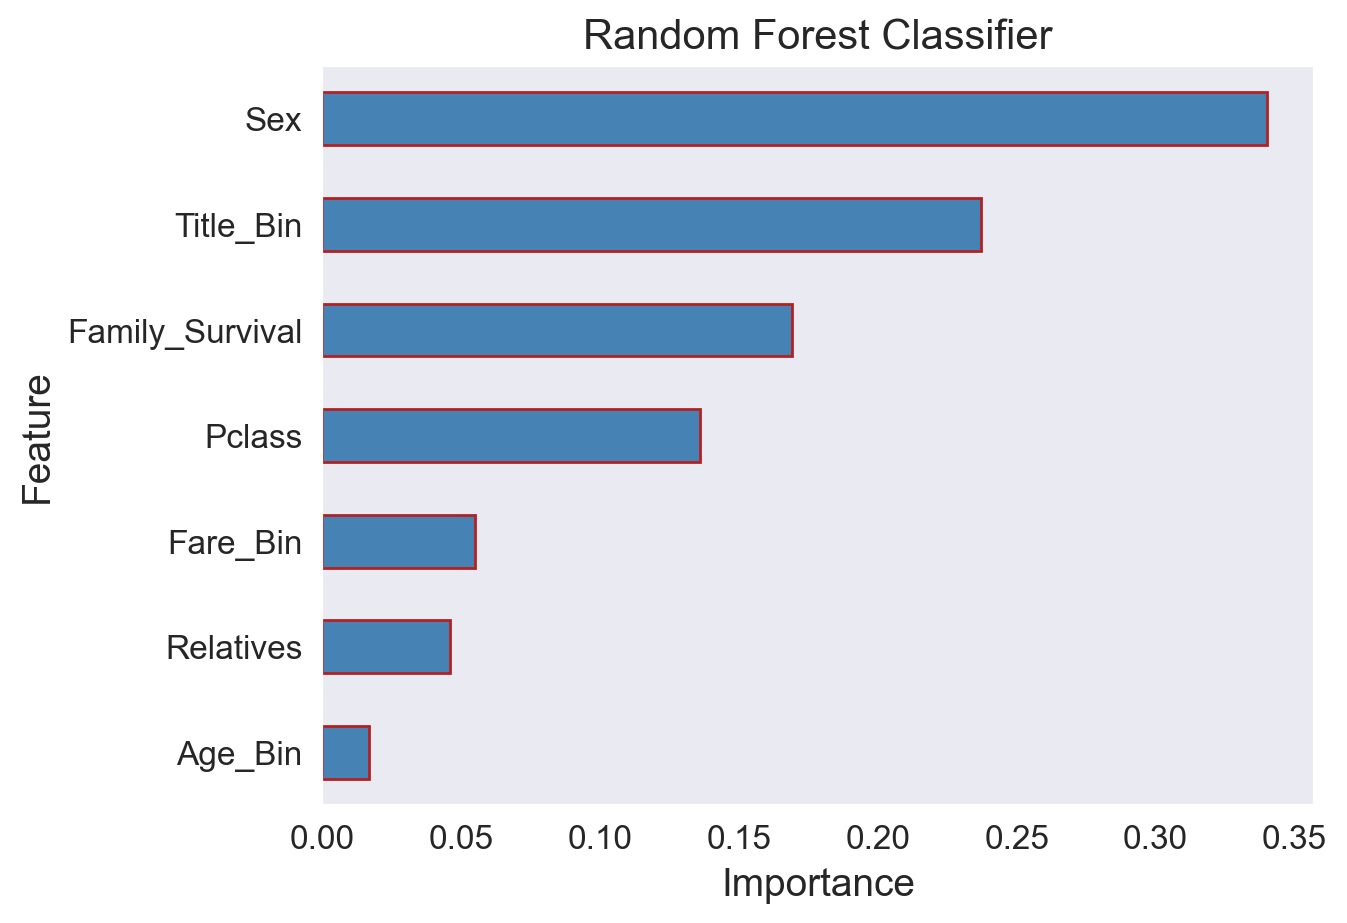

In [71]:
best_rf = best_clf_rf.best_estimator_

importances = pd.DataFrame({'Feature': X_train.columns,
                            'Importance': np.round(best_rf.feature_importances_, 3)})

importances = importances.sort_values('Importance', ascending = True).set_index('Feature')

importances.plot.barh(color = 'steelblue', edgecolor = 'firebrick', legend=False)
plt.title('Random Forest Classifier')
plt.xlabel('Importance');

**XGBoost 튜닝**: Gradient Boosting의 고성능 구현입니다. `learning_rate`, `n_estimators`, `max_depth`, `subsample`, `colsample_bytree`, `reg_alpha/lambda`(정규화) 등 다양한 파라미터를 탐색합니다.

### XGBoost 분류기

In [72]:
xgb = XGBClassifier(random_state = 42)

param_grid = {'n_estimators': [15, 25, 50, 100],
              'colsample_bytree': [0.65, 0.75, 0.80],
              'max_depth': [5],
              'reg_alpha': [1],
              'reg_lambda': [1, 2, 5],
              'subsample': [0.50, 0.75, 1.00],
              'learning_rate': [0.01, 0.1, 0.5],
              'gamma': [0.5, 1, 2, 5],
              'min_child_weight': [0.01],
              'sampling_method': ['uniform']}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled, y_train)
clf_performance(best_clf_xgb, 'XGB')

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
XGB
-------------------------------
   Best Score: 0.8540965207631874
   Best Parameters: {'colsample_bytree': 0.65, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0.01, 'n_estimators': 15, 'reg_alpha': 1, 'reg_lambda': 1, 'sampling_method': 'uniform', 'subsample': 1.0}


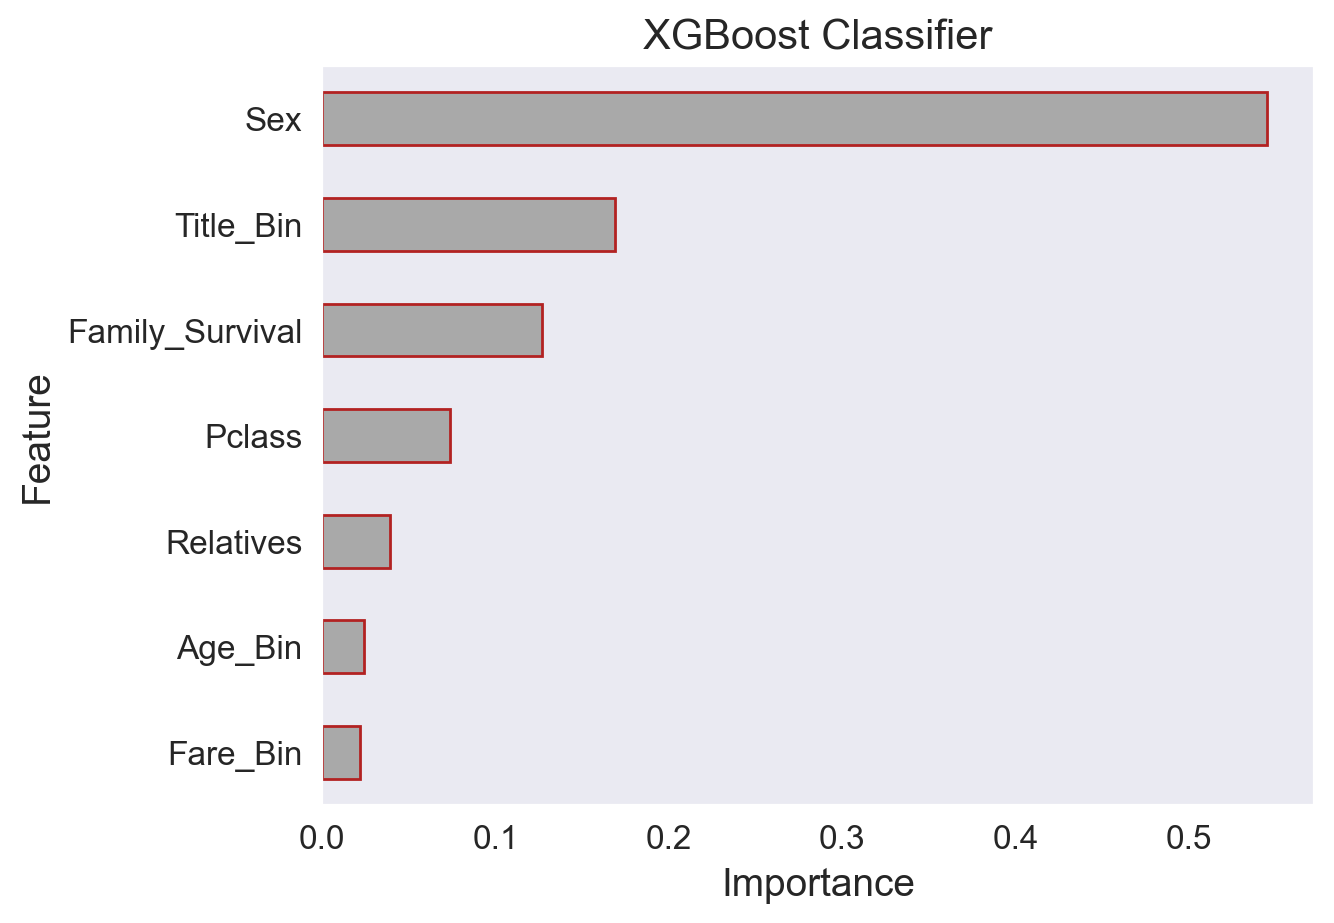

In [73]:
best_xgb = best_clf_xgb.best_estimator_

importances = pd.DataFrame({'Feature': X_train.columns,
                            'Importance': np.round(best_xgb.feature_importances_, 3)})

importances = importances.sort_values('Importance', ascending = True).set_index('Feature')

importances.plot.barh(color = 'darkgray', edgecolor = 'firebrick', legend = False)
plt.title('XGBoost Classifier')
plt.xlabel('Importance');

**AdaBoost 튜닝**: Adaptive Boosting 알고리즘입니다. 약한 학습기(weak learner)를 순차적으로 학습시키며, 이전에 잘못 분류된 샘플에 가중치를 높입니다. `estimator`에 Decision Tree를 사용합니다.

### AdaBoost (적응형 부스팅)

In [75]:
# scikit-learn 1.2+에서 base_estimator는 deprecated됨 → estimator 사용
adaDTC = AdaBoostClassifier(estimator = DecisionTreeClassifier(random_state = random_state), random_state=random_state)

param_grid = {#'algorithm': ['SAMME', 'SAMME.R'],
              'estimator__criterion' : ['gini', 'entropy'],
              'estimator__splitter' : ['best', 'random'],
              'n_estimators': [2, 5, 10, 50],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 1, 2]}

clf_ada = GridSearchCV(adaDTC, param_grid = param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 1)
best_clf_ada = clf_ada.fit(X_train_scaled, y_train)

clf_performance(best_clf_ada, 'AdaBost')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
AdaBost
-------------------------------
   Best Score: 0.8417425145941874
   Best Parameters: {'estimator__criterion': 'gini', 'estimator__splitter': 'random', 'learning_rate': 1, 'n_estimators': 5}


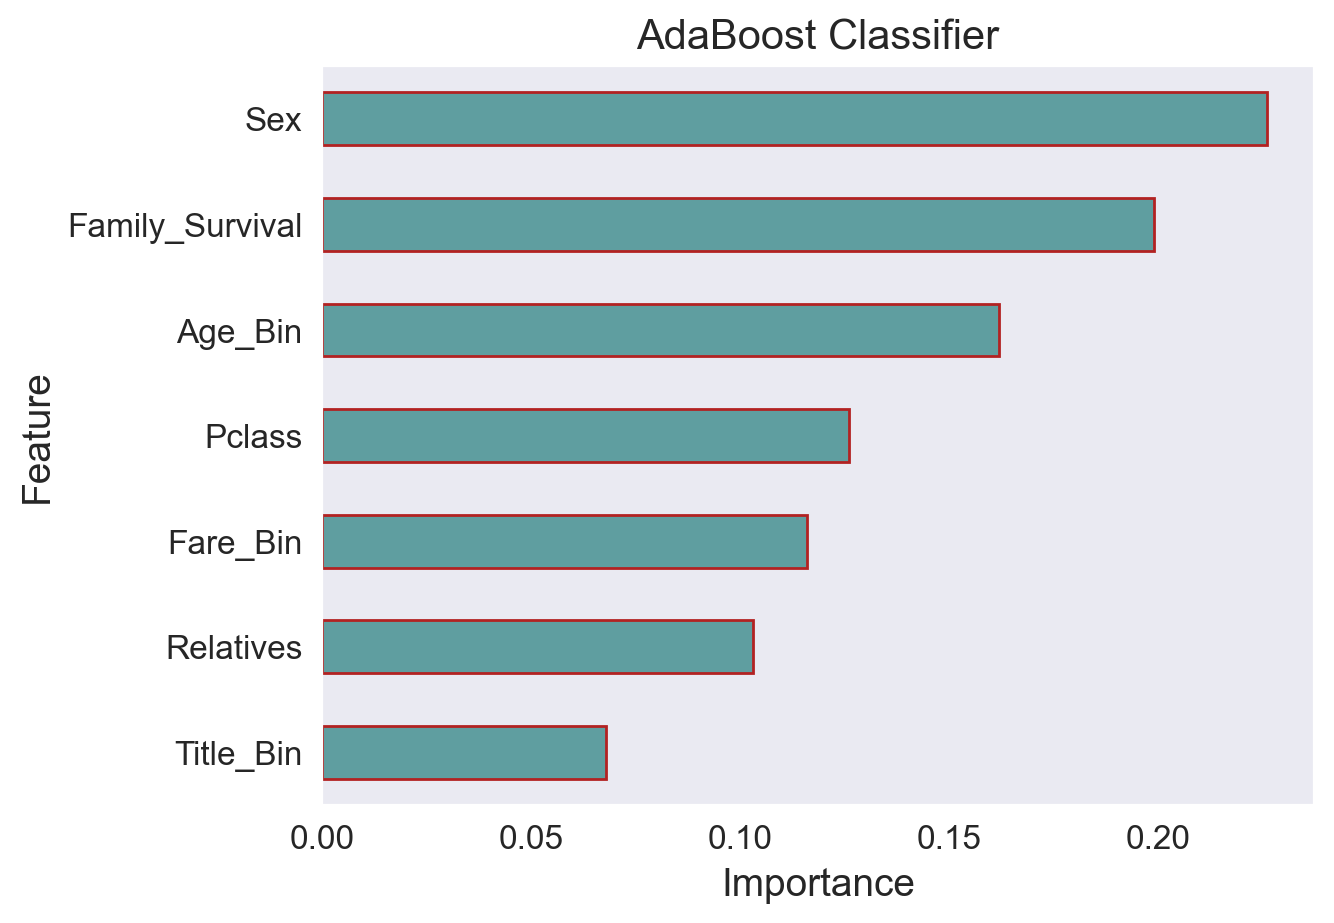

In [76]:
best_ada = best_clf_ada.best_estimator_
importances = pd.DataFrame({'Feature': X_train.columns,
                            'Importance': np.round(best_ada.feature_importances_, 3)})

importances = importances.sort_values('Importance', ascending = True).set_index('Feature')

importances.plot.barh(color = 'cadetblue', edgecolor = 'firebrick', legend = False)
plt.title('AdaBoost Classifier')
plt.xlabel('Importance');

결과는 다음과 같습니다:

In [77]:
cv_total = pd.DataFrame({'Algorithm': ['Gaussian Naive Bayes', 'Logistic Regression', 'k-Nearest Neighboors', 'SVC', 'Decision Tree', 'Random Forest', 'XGB Classifier', 'AdaBoost Classifier'],
                         'Baseline': cv_base_mean, 
                         'Tuned Performance': cv_means_tuned})

cv_total

,Algorithm,Baseline,Tuned Performance
0,Gaussian Naive Bayes,0.803,NaN
1,Logistic Regression,0.829,0.836
2,k-Nearest Neighboors,0.831,0.843
3,SVC,0.853,0.853
4,Decision Tree,0.825,0.853
5,Random Forest,0.837,0.852
6,XGB Classifier,0.834,0.854
7,AdaBoost Classifier,0.835,0.842


 이제 **최종 앙상블**을 구축하겠습니다 😌:

**최종 튜닝된 앙상블**: 튜닝된 각 모델의 `best_estimator_`를 추출하여 새로운 VotingClassifier를 구성합니다. 최적화된 모델들의 조합으로 약 85%의 교차 검증 정확도를 달성합니다.

In [78]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_dt = best_clf_dt.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb.best_estimator_
# best_ada = best_clf_ada.best_estimator_  # didn't help me in my final ensemble

estimators = [('lr', best_lr), ('knn', best_knn), ('svc', best_svc),
              ('rf', best_rf), ('xgb', best_xgb), ('dt', best_dt)]

tuned_voting_hard = VotingClassifier(estimators = estimators, voting = 'hard', n_jobs = -1)
tuned_voting_soft = VotingClassifier(estimators = estimators, voting = 'soft', n_jobs = -1)

tuned_voting_hard.fit(X_train_scaled, y_train)
tuned_voting_soft.fit(X_train_scaled, y_train)

cv_hard = cross_val_score(tuned_voting_hard, X_train_scaled, y_train, cv = 5)
cv_soft = cross_val_score(tuned_voting_soft, X_train_scaled, y_train, cv = 5)

print ('Tuned Models - Ensemble\n-----------------------')
print ('Hard Voting: {}%'.format(np.round(cv_hard.mean()*100, 2)))
print ('Soft Voting: {}%'.format(np.round(cv_soft.mean()*100, 2)))

y_pred_tuned_hd = tuned_voting_hard.predict(X_test_scaled).astype(int)
y_pred_tuned_sf = tuned_voting_soft.predict(X_test_scaled).astype(int)

Tuned Models - Ensemble
-----------------------
Hard Voting: 85.18%
Soft Voting: 85.41%


## 제출

**제출 파일 생성**: 테스트 데이터에 대한 예측 결과를 Kaggle 제출 형식(PassengerId, Survived)의 CSV 파일로 저장합니다. `to_csv(index=False)`로 인덱스 없이 저장합니다.

In [82]:
# submission 폴더가 없으면 생성해서 그 안에 csv 파일 저장
import os

# exist_ok : True, 없으면 만들고 있어도 괜찮. False면 없으면 에러
os.makedirs("submission", exist_ok=True)

In [84]:
test_df = pd.DataFrame(pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))['PassengerId'])

pd.DataFrame(data = {'PassengerId': test_df.PassengerId, 
                     'Survived': y_pred_base_hard.astype(int)}).to_csv(os.path.join('submission', '01-Baseline_Hard_voting.csv'), index = False)

pd.DataFrame(data = {'PassengerId': test_df.PassengerId, 
                     'Survived': y_pred_base_soft.astype(int)}).to_csv(os.path.join('submission', '02-Baseline_Soft_voting.csv'), index = False)

pd.DataFrame(data = {'PassengerId': test_df.PassengerId, 
                     'Survived': y_pred_tuned_hd.astype(int)}).to_csv(os.path.join('submission', '03-Tuned_Hard_Voting.csv'), index = False)

pd.DataFrame(data = {'PassengerId': test_df.PassengerId, 
                     'Survived': y_pred_tuned_sf.astype(int)}).to_csv(os.path.join('submission', '04-Tuned_Soft_Voting.csv'), index = False)

# 결론

이 노트북이 끝났습니다! 몇 가지 요점으로 요약할 수 있습니다:

- **EDA**는 어디에 **집중**해야 하는지 이해하는 데 도움이 되었습니다. 승객의 성별이나 호칭과 같은 요인은 [초기 가정](https://www.kaggle.com/c/titanic)이 실제로 맞았음을 보여주었으며, '생존에는 어느 정도의 운이 관련되어 있었지만, 일부 그룹의 사람들이 다른 사람들보다 생존할 가능성이 더 높았던 것 같습니다'.
- 주어진 특성에만 완전히 의존하지 말고 **새로운 특성을 만들어** 이점을 얻을 수 있습니다.
- 머신러닝 모델을 구축하려면 좋은/최적의 결과를 얻기 전에 많은 파라미터 **튜닝**이 필요합니다. **앙상블 학습**은 일반적으로 이 방향으로 도움이 됩니다.
- 마지막으로, 다른 사람의 작업을 보면 자신의 프로젝트에 대한 새로운 아이디어와 영감을 얻을 수 있습니다. **출처를 명시**하고 전체 커널을 복사하지 마세요.

댓글 섹션에서 무엇이든 질문해 주세요.

이 노트북이 마음에 들었다면 <font size=+0 color="red"><b>upvote</b></font>를 눌러주세요! 감사합니다! 😉